# Importando Bibliotecas

In [1]:
#Vincular drive no google colab
#drive.mount('/content/drive/')

In [2]:
#Instalacao de Todos os pacotes necessários para execução do código
#pip install chart_studio numpy pandas matplotlib joblib keras tensorflow scikit-learn plotly seaborn statsmodels scipy

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(42)
seed(42)

droprate = 0.3

# Pré-processamento dos dados

* Carregando os dados
* Dividindo em treino, teste e validação
* Padronizando os dados


### Carregando Dados e convertendo para Array do Numpy. Configurado apenas para séries univariadas

In [4]:
dataframe = pd.read_csv('dataframe.csv')

In [5]:
dataframe.head(5)

,index,hourly_demand
0,2022-10-09 17:00:00,65613.544
1,2022-10-09 18:00:00,71818.443
2,2022-10-09 19:00:00,72486.262
3,2022-10-09 20:00:00,71552.251
4,2022-10-09 21:00:00,70319.597


In [6]:
# Converter a coluna "Data" para datetime e definir como índice
dataframe['index'] = pd.to_datetime(dataframe['index'], errors='coerce')  # Tratar valores inválidos
dataframe = dataframe.dropna(subset=['index'])  # Remover valores inválidos
dataframe.set_index('index', inplace=True)

# Visualizar o dataframe após a transformação
print(dataframe.head())

                     hourly_demand
index                             
2022-10-09 17:00:00      65613.544
2022-10-09 18:00:00      71818.443
2022-10-09 19:00:00      72486.262
2022-10-09 20:00:00      71552.251
2022-10-09 21:00:00      70319.597


In [7]:
data = dataframe.values  # Converte o DataFrame para um array NumPy

### Train test split

In [8]:
# Definindo a proporção para treino, validação e teste
train_prop = 0.7
valid_prop = 0.15
test_prop = 0.15

In [9]:
# Tamanho Total de Cada Conjunto
total_data_len = len(dataframe)
train_data_len = int(np.floor(total_data_len * train_prop))
valid_data_len = int(np.floor(total_data_len * valid_prop))
test_data_len = int(np.floor(total_data_len * test_prop))
print(total_data_len)
print(train_data_len)
print(valid_data_len)
print(test_data_len)


2000
1400
300
300


### Criando Treino, Validacao e Teste sem Padronizacao dos dados

In [10]:
# # Criando conjuntos de treinamento
# train_data = data[0:train_data_len, :]
# X_train, Y_train = [], []
# for i in range(60, len(train_data)):
#     X_train.append(train_data[i-60:i, 0])
#     Y_train.append(train_data[i, 0])

# X_train, Y_train = np.array(X_train), np.array(Y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# print(len(X_train))
# print(len(Y_train))
# print(len(train_data))

In [11]:
# # Criando o conjunto de validação
# valid_data = data[train_data_len:train_data_len + valid_data_len, :]
# X_valid, Y_valid = [], []

# for i in range(60, len(valid_data)):
#     X_valid.append(valid_data[i-60:i, 0])
#     Y_valid.append(valid_data[i, 0])

# X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
# X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
# Y_valid = np.array(Y_valid)

# print(len(X_valid))
# print(len(Y_valid))
# print(len(valid_data))

In [12]:
# # Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
# test_data = data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
# Y_test = data[train_data_len + valid_data_len:, :]  # Permanece o mesmo

# X_test = []
# for i in range(60, len(test_data)):
#     X_test.append(test_data[i-60:i, 0])

# X_test = np.array(X_test)
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
# print(len(Y_test))
# print(len(test_data))

### Treino, Teste e Validacao com padronizacao dos dados

In [13]:
# Criando o escalador
scaler = MinMaxScaler(feature_range=(0,1))


# Salvar o scaler para uso posterior
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [14]:
# Definir o número de passos de entrada e saída
n_steps_in, n_steps_out = 168, 1

In [15]:
# Transformar de Series Temporais para Amostras e Saída
def create_supervised_data(data, n_steps_in, n_steps_out):
    X, Y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in, 0])  # Todas as colunas, exceto a última
        Y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out, 0])  # Apenas a última coluna
    return np.array(X), np.array(Y)

### Divisão e Padronização dos Dados

In [16]:
# Definir proporção de treino
train_size = int(len(data) * train_prop)

# Dividir o conjunto de treino
train_data = data[:train_size]

# Padronizar o conjunto de treino
train_scaled = scaler.fit_transform(train_data)

X_train, Y_train = create_supervised_data(train_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de treino
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)


X_train shape: (1232, 168)
Y_train shape: (1232, 1)


In [17]:
# Definir proporção de validação
valid_size = int(len(data) * valid_prop)

# Dividir o conjunto de validação
valid_data = data[train_size:train_size + valid_size]

# Padronizar o conjunto de validação (usando parâmetros do treino)
valid_scaled = scaler.transform(valid_data)

# Criar dados supervisionados para validação
X_valid, Y_valid = create_supervised_data(valid_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de validação
print("X_valid shape:", X_valid.shape)
print("Y_valid shape:", Y_valid.shape)


X_valid shape: (132, 168)
Y_valid shape: (132, 1)


In [18]:
# O restante dos dados será usado para teste
test_data = data[train_size + valid_size:]

# Padronizar o conjunto de teste (usando parâmetros do treino)
test_scaled = scaler.transform(test_data)

# Criar dados supervisionados para teste
X_test, Y_test = create_supervised_data(test_scaled, n_steps_in, n_steps_out)

# Verificar shapes do conjunto de teste
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_test shape: (132, 168)
Y_test shape: (132, 1)


### Conferindo Dimensão das Partições

In [19]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'Y_valid length: {len(Y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 1232
Y_train length: 1232
X_valid length: 132
Y_valid length: 132
X_test length: 132
Y_test length: 132


### Ajuste dos dados para os modelos LSTM e CNN

In [20]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (1232, 168, 1)
Validation set shape (132, 168, 1)
Test set shape (132, 168, 1)


# Funções de Métricas Utilizadas e Plot dos Resultados

In [21]:
# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)

    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100

    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.4f}%")

    return mae, mse, rmse, mape

In [22]:
# Função para exibir os gráficos lado a lado
def plot_multiple_predictions(train_valid_data, y_test, y_pred_models, model_names):
    # Definindo o tamanho da figura e o layout (2 gráficos por linha)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Achata o array de eixos para indexação direta

    for idx, (y_pred, model_name) in enumerate(zip(y_pred_models, model_names)):
        ax = axes[idx]

        # Plot dos dados de treino e validação
        ax.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")

        # Plot dos dados de teste
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")

        # Plot das previsões
        ax.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")

        # Configurações do gráfico
        ax.set_title(f'Ajuste do Modelo com Previsões: {model_name}')
        ax.set_xlabel("Tempo")
        ax.set_ylabel("Valor")
        ax.legend()

    # Ajusta o layout e exibe
    plt.tight_layout()
    plt.show()

In [23]:
def plot_multiple_loss(history_standard, history_reg, history_drop, history_reg_drop):

    # Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(history_standard.history['loss'], label='Treinamento')
    plt.plot(history_standard.history['val_loss'], label='Validação')
    plt.title('Modelo Simples: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(history_reg.history['loss'], label='Treinamento')
    plt.plot(history_reg.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(history_drop.history['loss'], label='Treinamento')
    plt.plot(history_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(history_reg_drop.history['loss'], label='Treinamento')
    plt.plot(history_reg_drop.history['val_loss'], label='Validação')
    plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [24]:
def plot_predicts(y_pred, y_pred_reg, y_pred_drop, y_pred_reg_drop):

    # Gráficos de predição
    plt.figure(figsize=(14, 10))

    # Modelo Simples
    plt.subplot(2, 2, 1)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred, label='Predito (Simples)', color='red')
    plt.title('Modelo Simples')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização
    plt.subplot(2, 2, 2)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg, label='Predito (Reg)', color='red')
    plt.title('Modelo com Regularização')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Dropout
    plt.subplot(2, 2, 3)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_drop, label='Predito (Drop)', color='red')
    plt.title('Modelo com Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    # Modelo com Regularização e Dropout
    plt.subplot(2, 2, 4)
    plt.plot(Y_test, label='Real', color='blue')
    plt.plot(y_pred_reg_drop, label='Predito (Reg + Drop)', color='red')
    plt.title('Modelo com Regularização e Dropout')
    plt.xlabel('Tempo')
    plt.ylabel('Valor')
    plt.legend()

    plt.tight_layout()
    plt.show()

# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

### Selecao de Hiperparametros

In [25]:
epochs_mlp = 50
batch_mlp = 32
lr = 0.001
neu_mlp1 = 256 #Quantidade de Neurônios Utilizados na Primeira Camada
neu_mlp2 = 64 #Quantidade de Neurônios Utilizados na Segunda Camada

### Analisando a Quantidade de Neuronios

In [26]:
# Função de criação do modelo MLP com 2 camadas ocultas
def create_mlp_model(neurons_layer_1, neurons_layer_2):
    model = Sequential()
    model.add(Dense(neurons_layer_1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(neurons_layer_2, activation='relu'))  # Segunda camada
    model.add(Dense(1))  # Camada de saída para regressão
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Listas de neurônios para a primeira e segunda camada
neurons_layer_1_options_mlp = [16, 32, 64, 128, 256]
neurons_layer_2_options_mlp = [16, 32, 64, 128, 256]

# Armazenar resultados
results_mlp = []

Treinando modelo com 16 neurônios na primeira camada e 16 na segunda camada...
Treinando modelo com 16 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 16 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 16 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 16 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 16 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 16 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 64 neurônios na primeira ca

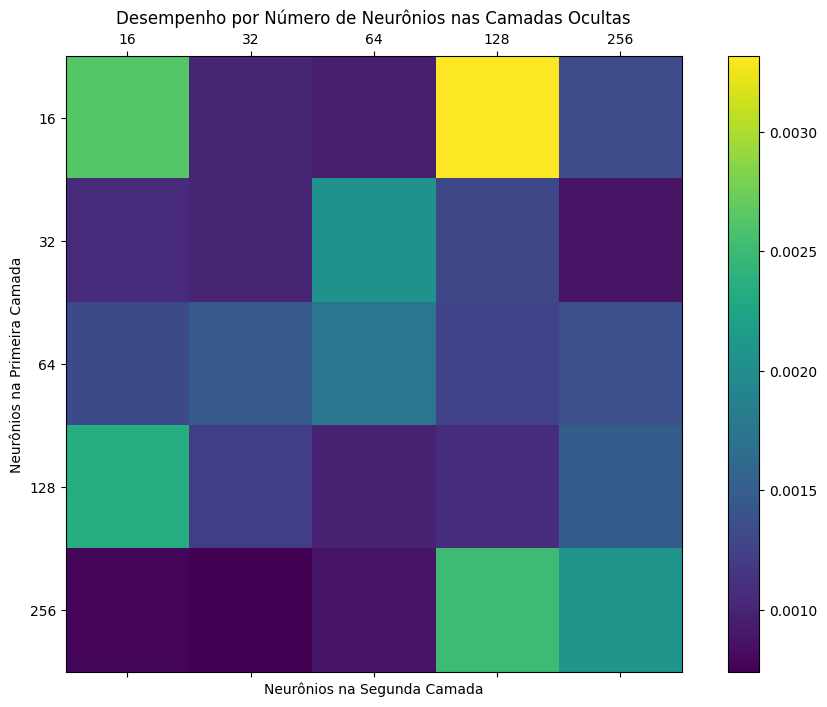

In [27]:
# Loop para testar todas as combinações possíveis de neurônios
for neurons_layer_1 in neurons_layer_1_options_mlp:
    for neurons_layer_2 in neurons_layer_2_options_mlp:
        print(f"Treinando modelo com {neurons_layer_1} neurônios na primeira camada e {neurons_layer_2} na segunda camada...")

        # Criar o modelo
        model = create_mlp_model(neurons_layer_1, neurons_layer_2)

        # Treinar o modelo
        history = model.fit(X_train, Y_train, epochs=epochs_mlp, batch_size=batch_mlp, validation_data=(X_valid, Y_valid), verbose=0)

        # Obter o desempenho (pode ser MAPE, RMSE, etc.)
        val_loss = history.history['val_loss'][-1]

        # Armazenar o desempenho
        results_mlp.append({'neurons_layer_1': neurons_layer_1, 'neurons_layer_2': neurons_layer_2, 'val_loss': val_loss})

# Converter para dataframe (opcional)
import pandas as pd
results_df_mlp = pd.DataFrame(results_mlp)

# Gerar gráfico
fig, ax = plt.subplots(figsize=(12,8))

# Gerar gráfico de calor (heatmap)
pivot_table_mlp = results_df_mlp.pivot(index='neurons_layer_1', columns='neurons_layer_2', values='val_loss')
cax = ax.matshow(pivot_table_mlp, cmap='viridis')

# Adicionar rótulos
ax.set_xticks(np.arange(len(neurons_layer_2_options_mlp)))
ax.set_yticks(np.arange(len(neurons_layer_1_options_mlp)))
ax.set_xticklabels(neurons_layer_2_options_mlp)
ax.set_yticklabels(neurons_layer_1_options_mlp)

# Adicionar título e legendas
plt.xlabel('Neurônios na Segunda Camada')
plt.ylabel('Neurônios na Primeira Camada')
plt.title('Desempenho por Número de Neurônios nas Camadas Ocultas')
fig.colorbar(cax)

plt.show()

### Implementacao e ajuste do Modelo MLP

In [28]:
model_mlp = Sequential()
model_mlp.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(neu_mlp2))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp.summary()

In [29]:
history_mlp = model_mlp.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_mlp,
                            batch_size=batch_mlp,
                            verbose=0)

### Implementacao e Ajuste do Modelo MLP com regularização

In [30]:
model_mlp_reg = Sequential()
model_mlp_reg.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1],
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(neu_mlp2, activation='relu',
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_mlp_reg.add(Dense(1))  # Saída
model_mlp_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_reg.summary()

In [31]:
history_mlp_reg = model_mlp_reg.fit(X_train,
                                    Y_train,
                                    validation_data=(X_valid, Y_valid),
                                    epochs=epochs_mlp,
                                    batch_size=batch_mlp,
                                    verbose=1)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.8834 - val_loss: 1.9476
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7405 - val_loss: 1.2470
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1343 - val_loss: 0.8460
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7792 - val_loss: 0.6015
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5573 - val_loss: 0.4384
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4084 - val_loss: 0.3264
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3044 - val_loss: 0.2455
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2299 - val_loss: 0.1874
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1760 - val_loss: 0.1449
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1366 - val_loss: 0.1136
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1075 - val_loss: 0.0905
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0858 - val_lo

### Implementacao e ajuste do modelo MLP com Dropout

In [32]:
model_mlp_drop = Sequential()
model_mlp_drop.add(Dense(neu_mlp1, activation='relu', input_dim=X_train.shape[1]))
model_mlp_drop.add(Dropout(droprate))
model_mlp_drop.add(Dense(neu_mlp2, activation='relu'))
model_mlp_drop.add(Dropout(droprate))
model_mlp_drop.add(Dense(1))
model_mlp_drop.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr))
# model_mlp_dropout.summary()



In [33]:
#history_mlp_drop = model_mlp_dropout.fit(X_train, Y_train,
#                            validation_data=(X_valid, Y_valid),
#                            epochs=epochs_mlp,
#                            verbose=2)

history_mlp_drop = model_mlp_drop.fit(X_train,
                                        Y_train,
                                        validation_data=(X_valid, Y_valid),
                                        epochs=epochs_mlp,
                                        batch_size=batch_mlp,
                                        verbose=1)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3088 - val_loss: 0.0182
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - val_loss: 0.0124
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321 - val_loss: 0.0098
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300 - val_loss: 0.0100
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - val_loss: 0.0062
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0063
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0052
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0184 - val_loss: 0.0064
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.0063
Epoch 10/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0063
Epoch 11/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0027
Epoch 12/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - val_lo

### Implementando e Ajustando modelo MLP com Regularização e Dropout

In [34]:
# Definição do modelo MLP com regularização e dropout
model_mlp_reg_drop = Sequential()
model_mlp_reg_drop.add(Dense(neu_mlp1, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(droprate)) 
model_mlp_reg_drop.add(Dense(neu_mlp2, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp_reg_drop.add(Dropout(droprate))
model_mlp_reg_drop.add(Dense(1))  # Camada de saída
model_mlp_reg_drop.compile(optimizer=optimizers.Adam(lr), loss='mse', metrics=['mae'])

In [35]:
history_mlp_reg_drop = model_mlp_reg_drop.fit(X_train,
                                              Y_train,
                                              validation_data=(X_valid, Y_valid),
                                              epochs=epochs_mlp,
                                              batch_size=batch_mlp,
                                              verbose=1)


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5906 - mae: 0.3934 - val_loss: 0.2675 - val_mae: 0.1208
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2855 - mae: 0.1736 - val_loss: 0.2351 - val_mae: 0.1112
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2483 - mae: 0.1473 - val_loss: 0.2126 - val_mae: 0.1016
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2236 - mae: 0.1308 - val_loss: 0.1899 - val_mae: 0.0552
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2097 - mae: 0.1308 - val_loss: 0.1779 - val_mae: 0.0533
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1936 - mae: 0.1179 - val_loss: 0.1682 - val_mae: 0.0575
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1808 - mae: 0.1088 - val_loss: 0.1626 - val_mae: 0.0791
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1689 - mae: 0.1032 - val_loss: 0.1530 - val_mae: 0.0766
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1616 - mae: 

## Comparando os 4 modelos

In [36]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_mlp_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_mlp_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_mlp_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Modelo Padrão:
MAE: 0.0323
MSE: 0.0016
RMSE: 0.0400
MAPE: 7.9098%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Modelo com Regularização:
MAE: 0.0531
MSE: 0.0040
RMSE: 0.0629
MAPE: 13.4989%
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019FB67B2980> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━

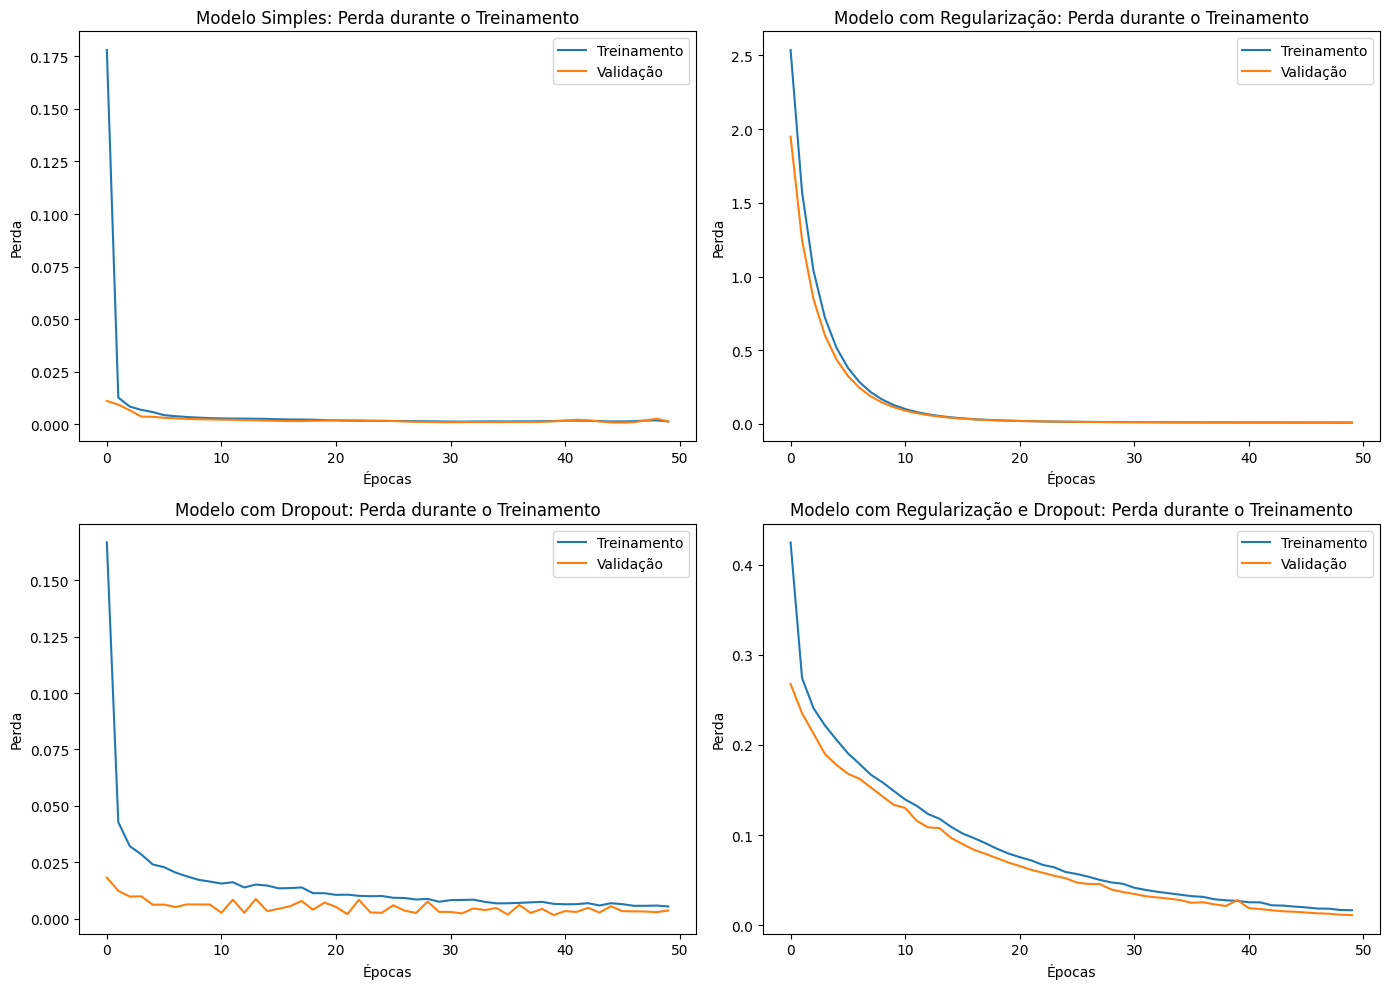

In [37]:
#Plot do Grafico de Perda
plot_multiple_loss(history_mlp, history_mlp_reg, history_mlp_drop, history_mlp_reg_drop)

In [38]:
# Gerando previsões para cada modelo
y_pred_mlp = model_mlp.predict(X_test)
y_pred_mlp_reg = model_mlp_reg.predict(X_test)
y_pred_mlp_drop = model_mlp_drop.predict(X_test)
y_pred_mlp_reg_drop = model_mlp_reg_drop.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


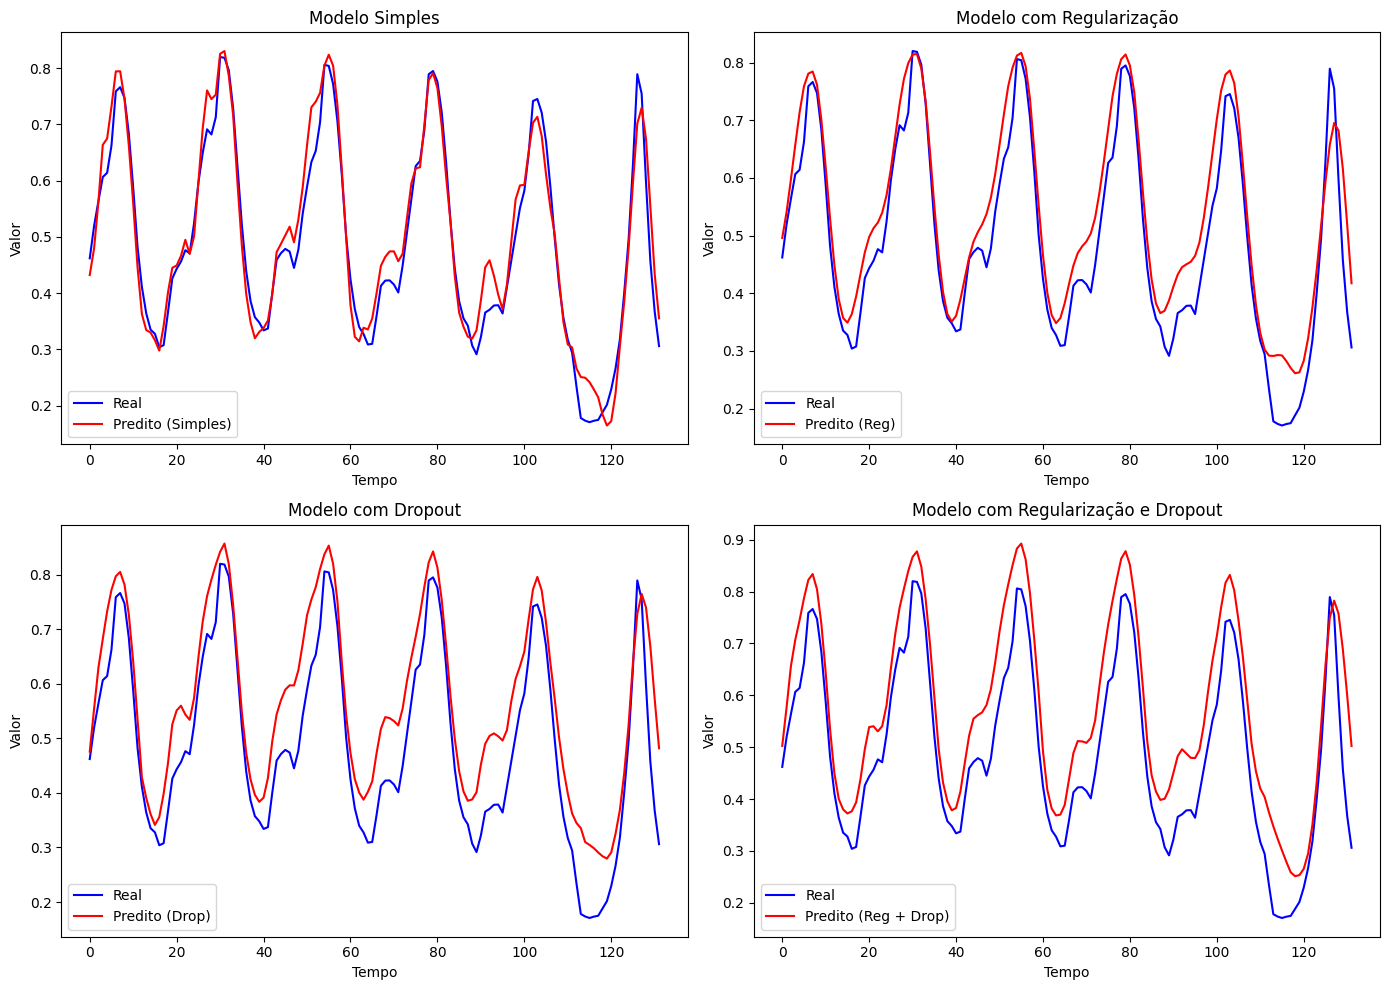

In [39]:
plot_predicts(y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop)

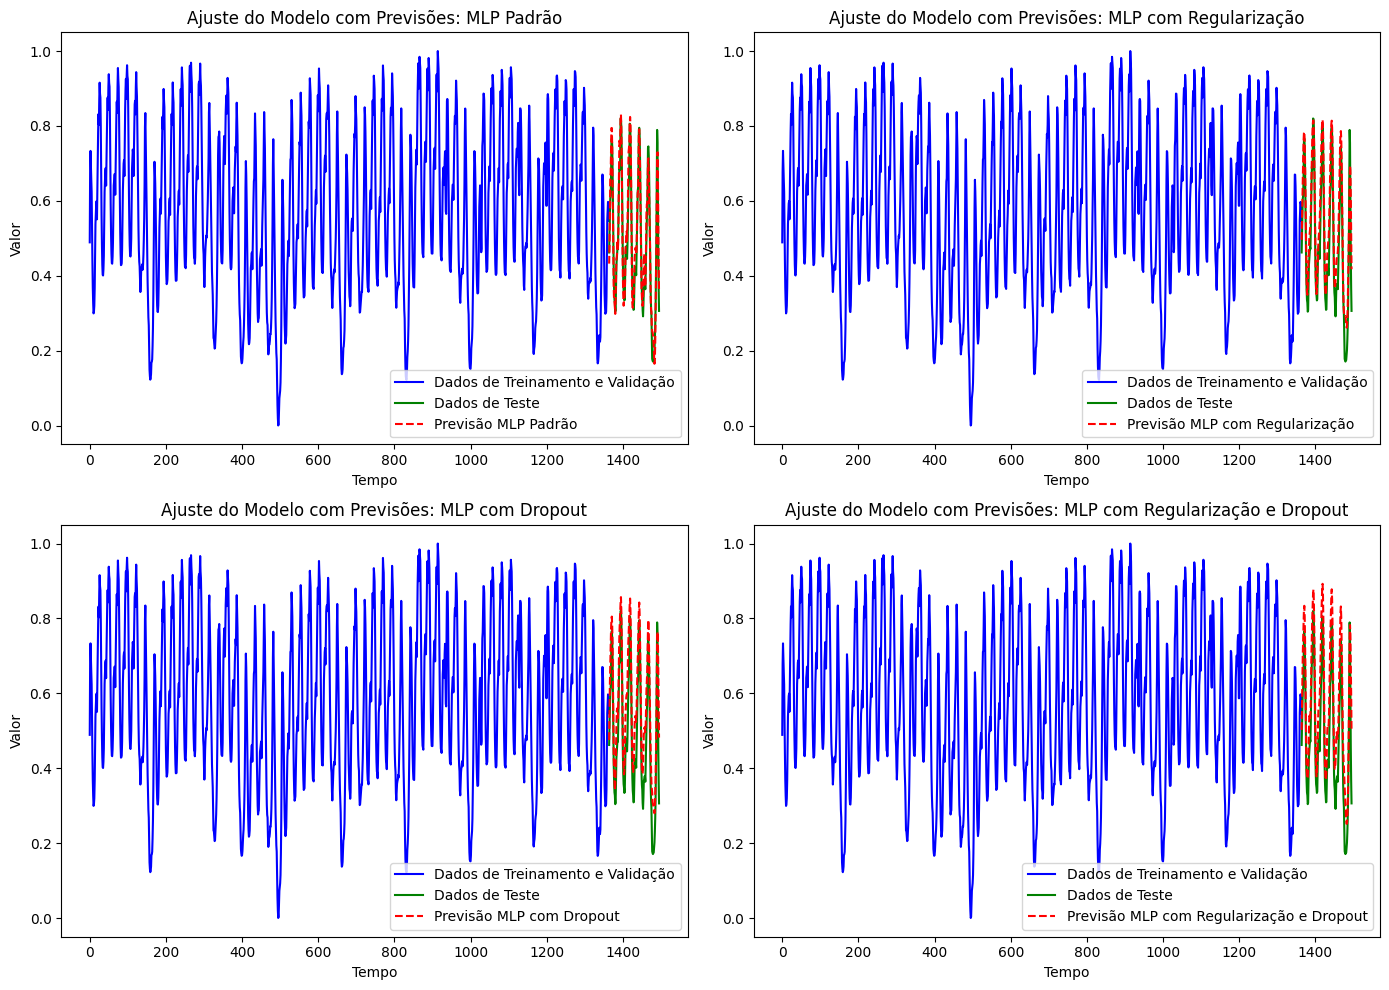

In [40]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_mlp, y_pred_mlp_reg, y_pred_mlp_drop, y_pred_mlp_reg_drop]
model_names = ["MLP Padrão", "MLP com Regularização", "MLP com Dropout", "MLP com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)


# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

## Seleção de Hiperparametros

In [41]:
#Hiperparametros
epochs_cnn = 30
batch_cnn = 32
lr_cnn = 0.001
neu_cnn1 = 32 # Quantidade De Neuronios da Primeira camada
neu_cnn2 = 32 #Quantidade de Neuronios da Segunda Camada

### Analisando a Quantidade de Neuronios

In [42]:
# Função de criação do modelo MLP com 2 camadas ocultas
def create_mlp_model(neurons_layer_1, neurons_layer_2):
    model_cnn = Sequential()
    model_cnn.add(Conv1D(filters=neurons_layer_1, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
    model_cnn.add(MaxPooling1D(pool_size=2))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(neurons_layer_2, activation='relu'))
    model_cnn.add(Dense(1))
    model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
    return model

# Listas de neurônios para a primeira e segunda camada
neurons_layer_1_options_cnn = [32, 64, 128, 256]
neurons_layer_2_options_cnn = [32, 64, 128, 256]

# Armazenar resultados
results_cnn = []

Treinando modelo com 32 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 256 neurônios na prim

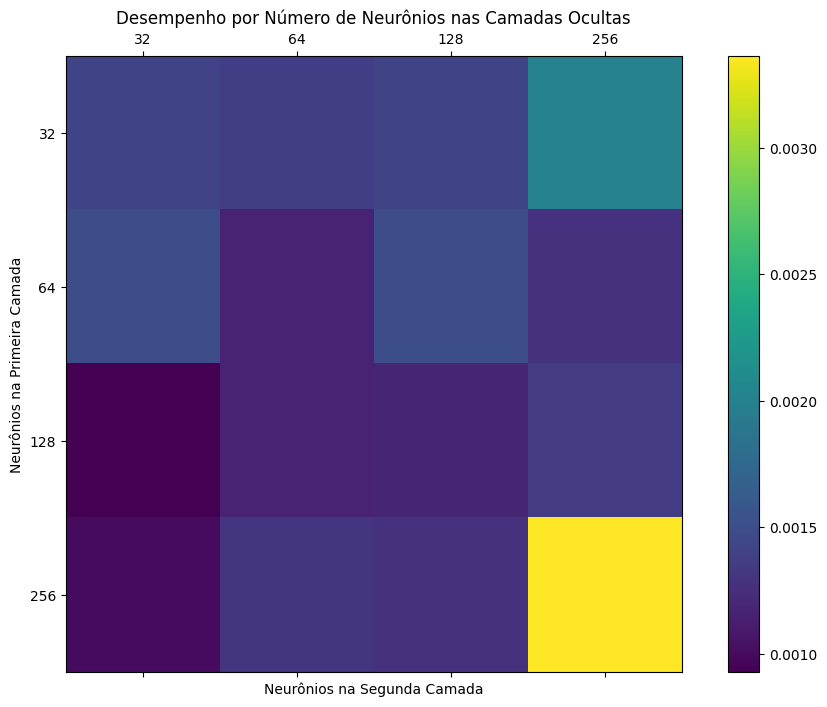

In [43]:

# Loop para testar todas as combinações possíveis de neurônios
for neurons_layer_1 in neurons_layer_1_options_cnn:
    for neurons_layer_2 in neurons_layer_2_options_cnn:
        print(f"Treinando modelo com {neurons_layer_1} neurônios na primeira camada e {neurons_layer_2} na segunda camada...")

        # Criar o modelo
        model = create_mlp_model(neurons_layer_1, neurons_layer_2)

        # Treinar o modelo
        history = model.fit(X_train, Y_train, epochs=35, batch_size=32, validation_data=(X_valid, Y_valid), verbose=0)

        # Obter o desempenho (pode ser MAPE, RMSE, etc.)
        val_loss = history.history['val_loss'][-1]

        # Armazenar o desempenho
        results_cnn.append({'neurons_layer_1': neurons_layer_1, 'neurons_layer_2': neurons_layer_2, 'val_loss': val_loss})


results_df_cnn = pd.DataFrame(results_cnn)

# Gerar gráfico
fig, ax = plt.subplots(figsize=(12,8))

# Gerar gráfico de calor (heatmap)
pivot_table = results_df_cnn.pivot(index='neurons_layer_1', columns='neurons_layer_2', values='val_loss')
cax = ax.matshow(pivot_table, cmap='viridis')

# Adicionar rótulos
ax.set_xticks(np.arange(len(neurons_layer_2_options_cnn)))
ax.set_yticks(np.arange(len(neurons_layer_1_options_cnn)))
ax.set_xticklabels(neurons_layer_2_options_cnn)
ax.set_yticklabels(neurons_layer_1_options_cnn)

# Adicionar título e legendas
plt.xlabel('Neurônios na Segunda Camada')
plt.ylabel('Neurônios na Primeira Camada')
plt.title('Desempenho por Número de Neurônios nas Camadas Ocultas')
fig.colorbar(cax)

plt.show()


## Implementando e Ajustando Modelo CNN

In [44]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(neu_cnn2, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn.summary()

In [45]:
history_cnn = model_cnn.fit(X_train,
                            Y_train,
                            validation_data=(X_valid, Y_valid),
                            epochs=epochs_cnn,
                            batch_size=batch_cnn,
                            verbose=1)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0830 - val_loss: 0.0229
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0098
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0078
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0068
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0053
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0051
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0041
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0032
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0025
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0052 - val_l

## Implementando e Ajustando Modelo CNN com Regularização L2

In [46]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu',
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(neu_cnn2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg.summary()


In [47]:
#history_cnn_reg = model_cnn_reg.fit(X_train_series, Y_train,
#                            validation_data=(X_valid_series, Y_valid),
#                            epochs=epochs_cnn,
#                            verbose=2)

history_cnn_reg = model_cnn_reg.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.5582 - val_loss: 0.2244
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1887 - val_loss: 0.1482
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1325 - val_loss: 0.1075
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0981 - val_loss: 0.0815
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0766 - val_loss: 0.0609
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0603 - val_loss: 0.0509
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0487 - val_loss: 0.0434
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0401 - val_loss: 0.0362
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0338 - val_loss: 0.0313
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0295 - val_loss: 0.0281
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0263 - val_loss: 0.0254
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0235 - val_lo

## Implementando e Ajustando Modelo CNN com Dropout

In [48]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(droprate))
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(neu_cnn2, activation='relu'))
model_cnn_drop.add(Dropout(droprate))
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_drop.summary()

In [49]:
history_cnn_drop = model_cnn_drop.fit(X_train_series,
                                    Y_train,
                                    validation_data=(X_valid_series, Y_valid),
                                    epochs=epochs_cnn,
                                    batch_size=batch_cnn,
                                    verbose=1)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1061 - val_loss: 0.0138
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0384 - val_loss: 0.0087
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - val_loss: 0.0059
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308 - val_loss: 0.0040
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0297 - val_loss: 0.0046
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0276 - val_loss: 0.0038
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0238 - val_loss: 0.0068
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - val_loss: 0.0032
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 - val_loss: 0.0031
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - val_loss: 0.0037
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221 - val_loss: 0.0027
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_lo

## Implementando e Ajustando Modelo CNN com Regularização e Dropout

In [50]:
model_cnn_reg_drop = Sequential()
model_cnn_reg_drop.add(Conv1D(filters=neu_cnn1, kernel_size=2, activation='relu',
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg_drop.add(MaxPooling1D(pool_size=2))
model_cnn_reg_drop.add(Dropout(droprate))
model_cnn_reg_drop.add(Flatten())
model_cnn_reg_drop.add(Dense(neu_cnn2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg_drop.add(Dropout(droprate))
model_cnn_reg_drop.add(Dense(1))
model_cnn_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_cnn))
# model_cnn_reg_drop.summary()

In [51]:
history_cnn_reg_drop = model_cnn_reg_drop.fit(X_train_series,
                                            Y_train,
                                            validation_data=(X_valid_series, Y_valid),
                                            epochs=epochs_cnn,
                                            batch_size=batch_cnn,
                                            verbose=1)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5477 - val_loss: 0.1759
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1662 - val_loss: 0.0942
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1064 - val_loss: 0.0735
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0812 - val_loss: 0.0539
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0645 - val_loss: 0.0414
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0544 - val_loss: 0.0311
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0449 - val_loss: 0.0357
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0407 - val_loss: 0.0275
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362 - val_loss: 0.0285
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - val_loss: 0.0202
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0330 - val_loss: 0.0239
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0314 - val_lo

## Comparando os 4 Modelos CNN

In [52]:
# Previsões
y_pred_cnn = model_cnn.predict(X_test)
y_pred_cnn_reg = model_cnn_reg.predict(X_test)
y_pred_cnn_drop = model_cnn_drop.predict(X_test)
y_pred_cnn_reg_drop = model_cnn_reg_drop.predict(X_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [53]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo Padrão:
MAE: 0.0414
MSE: 0.0030
RMSE: 0.0552
MAPE: 10.5170%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Regularização:
MAE: 0.0506
MSE: 0.0041
RMSE: 0.0640
MAPE: 13.7521%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Dropout:
MAE: 0.0487
MSE: 0.0044
RMSE: 0.0660
MAPE: 12.4023%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Modelo com Regularização e Dropout:
MAE: 0.0813
MSE: 0.0094
RMSE: 0.0968
MAPE: 23.2246%


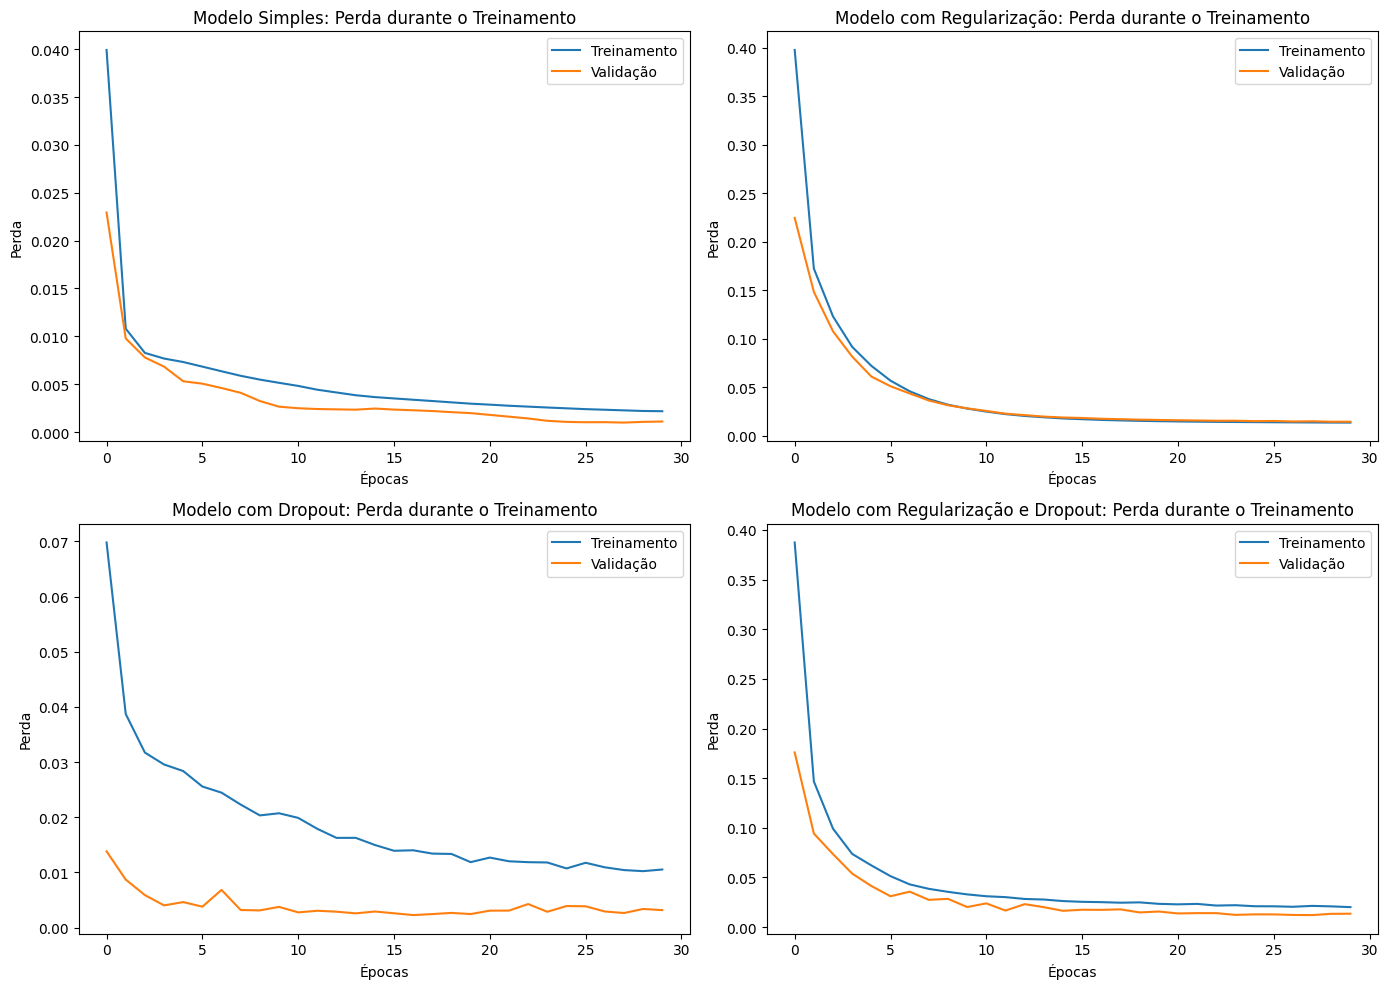

In [54]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn, history_cnn_reg, history_cnn_drop, history_cnn_reg_drop)

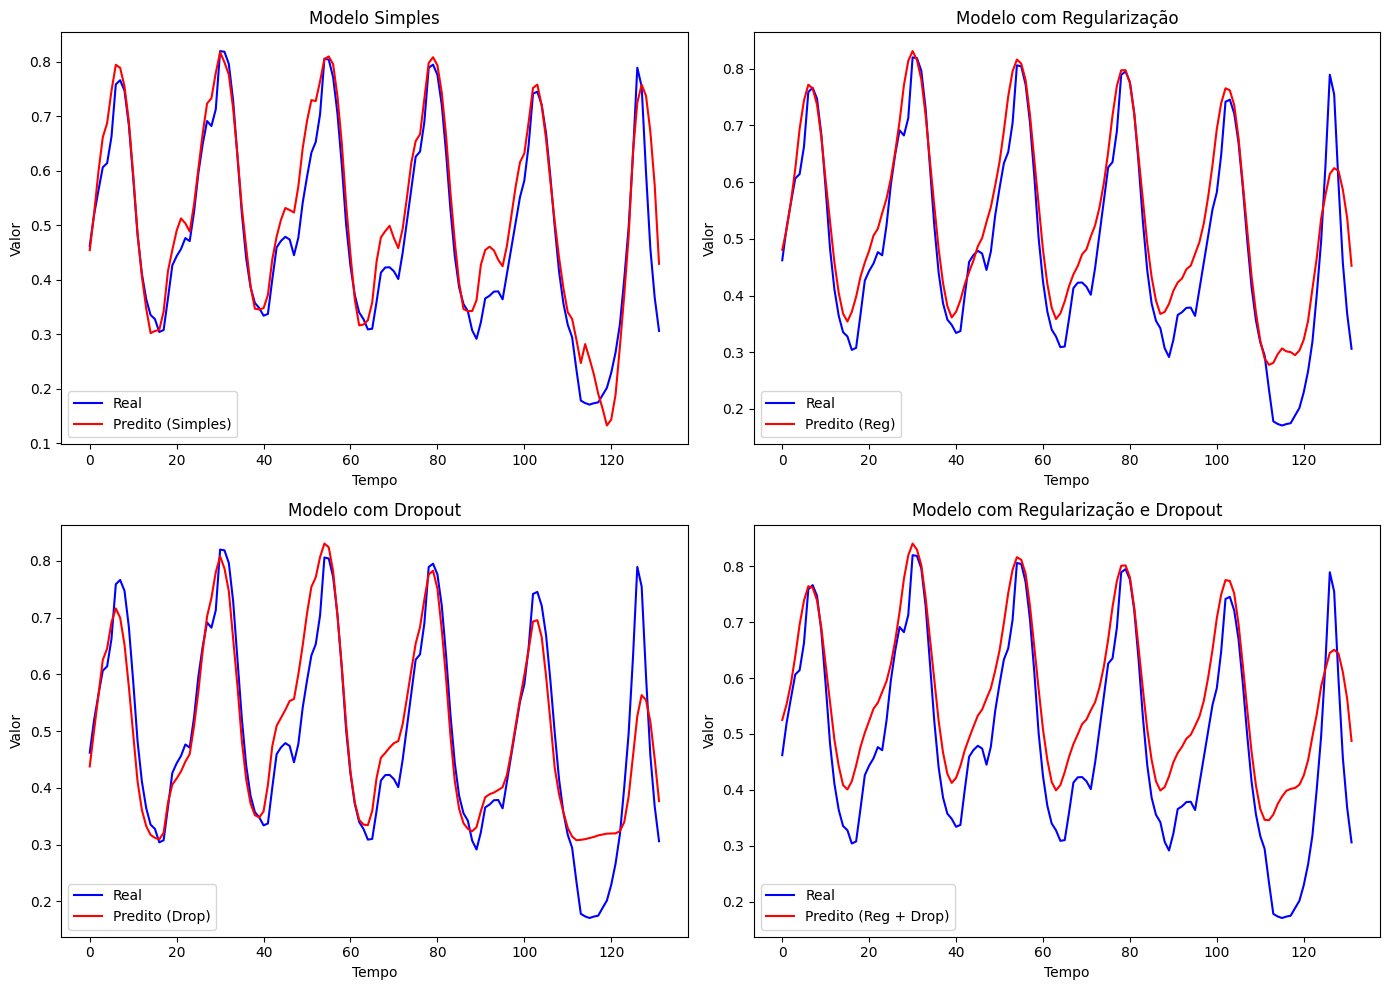

In [55]:
plot_predicts(y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop)

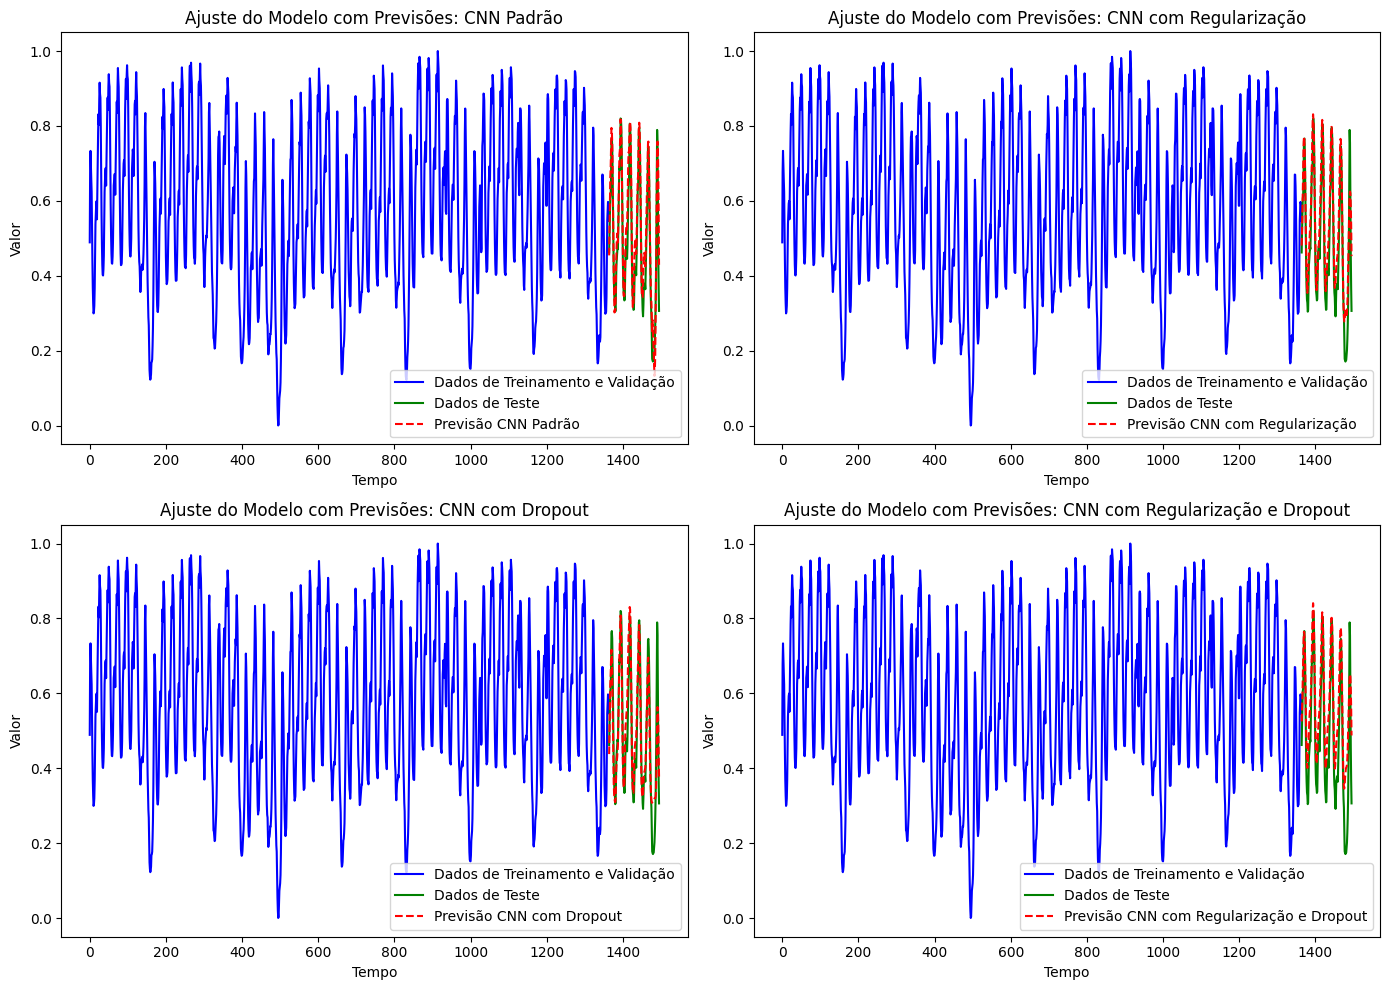

In [56]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn, y_pred_cnn_reg, y_pred_cnn_drop, y_pred_cnn_reg_drop]
model_names = ["CNN Padrão", "CNN com Regularização", "CNN com Dropout", "CNN com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

## Pre-procesamento dos dados

In [57]:
#Hiperparametros
epochs_lstm = 30
batch_lstm = 32
lr_lstm = 0.001
neu_lstm1 = 16 #Quantidade de Neuronios da Primeira Camada
neu_lstm2 = 32 #Quantidade de Neuronios da Segunda Camada

### Analisando Quantidade de Neuronios

In [58]:
# Definir a função de criação do modelo MLP (como exemplo)
def create_mlp_model(neurons):
    model_lstm_test = Sequential()
    model_lstm_test.add(LSTM(neurons, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
    model_lstm_test.add(Dense(1))
    model_lstm_test.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
    return model

# Lista de diferentes quantidades de neurônios a testar
neurons_options = [16, 24, 32, 48, 64, 82, 128, 256, 512]

# Armazenar resultados
results_lstm = []

Treinando modelo com 16 neurônios...
Treinando modelo com 24 neurônios...
Treinando modelo com 32 neurônios...
Treinando modelo com 48 neurônios...
Treinando modelo com 64 neurônios...
Treinando modelo com 82 neurônios...
Treinando modelo com 128 neurônios...
Treinando modelo com 256 neurônios...
Treinando modelo com 512 neurônios...


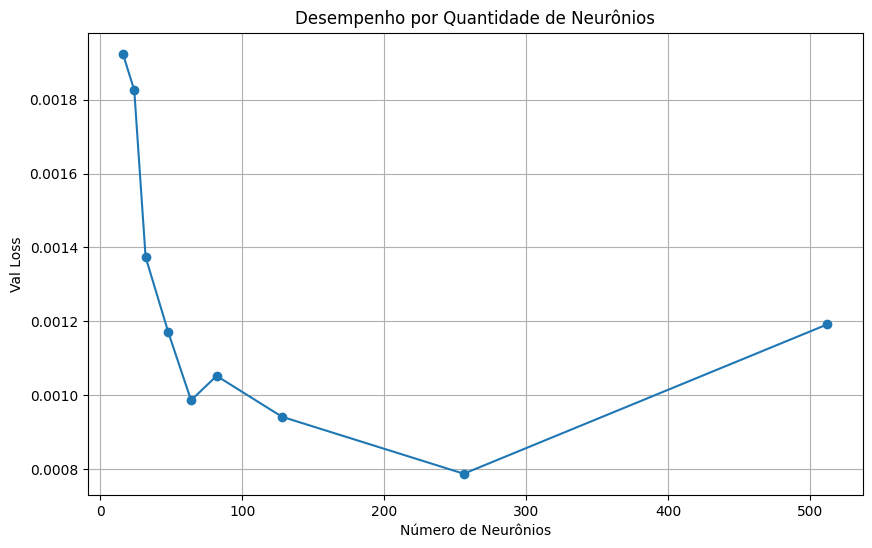

In [59]:
# Loop para testar diferentes quantidades de neurônios
for neurons in neurons_options:
    print(f"Treinando modelo com {neurons} neurônios...")
    
    # Criar o modelo
    model = create_mlp_model(neurons)
    
    # Treinar o modelo
    history = model.fit(X_train, Y_train, epochs=epochs_lstm, batch_size=batch_lstm, validation_data=(X_valid, Y_valid), verbose=0)
    
    # Obter o desempenho (pode ser MAPE, RMSE, etc.)
    val_loss = history.history['val_loss'][-1]
    
    # Armazenar o desempenho
    results_lstm.append({'neurons': neurons, 'val_loss': val_loss})

# Converter para dataframe (opcional)
import pandas as pd
results_lstm_df = pd.DataFrame(results_lstm)

# Gerar gráfico
plt.figure(figsize=(10,6))
plt.plot(results_lstm_df['neurons'], results_lstm_df['val_loss'], marker='o')
plt.title('Desempenho por Quantidade de Neurônios')
plt.xlabel('Número de Neurônios')
plt.ylabel('Val Loss')
plt.grid(True)
plt.show()

## Implementacao e Ajuste do Modelo LSTM

In [60]:
model_lstm = Sequential()
model_lstm.add(LSTM(neu_lstm1, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm.summary()

In [61]:
history_lstm = model_lstm.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=1)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.3063 - val_loss: 0.0891
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0616 - val_loss: 0.0276
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0312 - val_loss: 0.0263
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0280 - val_loss: 0.0236
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2393902.7500 - val_loss: 0.0407
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0558 - val_loss: 0.0537
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0632 - val_loss: 0.0535
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0629 - val_loss: 0.0530
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0623 - val_loss: 0.0525
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0618 - val_loss: 0.0520
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0612 - val_loss: 0.0515
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - los

## Implementacao e Ajuste do Modelo LSTM com Regularizacao L2

In [62]:
model_lstm_reg = Sequential()
model_lstm_reg.add(LSTM(neu_lstm1, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_reg.add(Dense(1))
model_lstm_reg.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_reg.summary()


In [63]:
history_lstm_reg = model_lstm_reg.fit(X_train_series,
                              Y_train,
                              validation_data=(X_valid, Y_valid),
                              epochs=epochs_lstm,
                              batch_size = batch_lstm,
                                verbose=0)


## Implementacao e Ajuste do Modelo LSTM com Dropout

In [64]:
model_lstm_drop = Sequential()
model_lstm_drop.add(LSTM(neu_lstm1, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm_drop.add(Dropout(droprate))
model_lstm_drop.add(Dense(1))
model_lstm_drop.compile(optimizer=optimizers.Adam(lr_lstm), loss='mse')
#model_lstm_dropout.summary()


In [65]:
# Treinamento do modelo com Dropout
history_lstm_drop = model_lstm_drop.fit(X_train_series,
                                              Y_train,
                                              epochs=epochs_lstm,
                                              batch_size=batch_lstm,
                                              validation_data=(X_valid, Y_valid),
                                              verbose=1)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.2828 - val_loss: 0.0281
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.1044 - val_loss: 0.0309
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0784 - val_loss: 0.0269
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0635 - val_loss: 0.0257
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0546 - val_loss: 0.0269
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0471 - val_loss: 0.0251
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0453 - val_loss: 0.0242
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0469 - val_loss: 0.0238
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0445 - val_loss: 0.0229
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0424 - val_loss: 0.0225
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0397 - val_loss: 0.0218
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0

## Implementacao e Ajuste do Modelo LSTM com Regularizacao e Dropout

In [66]:
model_lstm_reg_drop = Sequential()
model_lstm_reg_drop.add(
    LSTM(
        neu_lstm1,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
        input_shape=(X_train_series.shape[1], X_train_series.shape[2])
    )
)
model_lstm_reg_drop.add(Dropout(droprate))
model_lstm_reg_drop.add(Dense(1))
model_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_lstm))
#model_lstm_reg_dropout.summary()


In [67]:
history_lstm_reg_drop = model_lstm_reg_drop.fit(X_train_series,
                            Y_train,
                            epochs=epochs_lstm,
                            batch_size=batch_lstm,
                            validation_data=(X_valid, Y_valid),
                            verbose=2)

Epoch 1/30
39/39 - 4s - 92ms/step - loss: 0.1284 - val_loss: 0.0382
Epoch 2/30
39/39 - 2s - 64ms/step - loss: 0.0683 - val_loss: 0.0358
Epoch 3/30
39/39 - 2s - 40ms/step - loss: 0.0562 - val_loss: 0.0311
Epoch 4/30
39/39 - 1s - 37ms/step - loss: 0.0544 - val_loss: 0.0290
Epoch 5/30
39/39 - 2s - 40ms/step - loss: 0.0498 - val_loss: 0.0272
Epoch 6/30
39/39 - 1s - 38ms/step - loss: 0.0463 - val_loss: 0.0261
Epoch 7/30
39/39 - 1s - 38ms/step - loss: 0.0426 - val_loss: 0.0247
Epoch 8/30
39/39 - 3s - 65ms/step - loss: 0.0413 - val_loss: 0.0241
Epoch 9/30
39/39 - 2s - 39ms/step - loss: 0.0395 - val_loss: 0.0221
Epoch 10/30
39/39 - 3s - 66ms/step - loss: 0.0347 - val_loss: 0.0214
Epoch 11/30
39/39 - 3s - 68ms/step - loss: 0.0363 - val_loss: 0.0200
Epoch 12/30
39/39 - 3s - 67ms/step - loss: 0.0327 - val_loss: 0.0190
Epoch 13/30
39/39 - 2s - 40ms/step - loss: 0.0294 - val_loss: 0.0179
Epoch 14/30
39/39 - 1s - 38ms/step - loss: 0.0295 - val_loss: 0.0164
Epoch 15/30
39/39 - 2s - 42ms/step - loss: 

## Comparativo entre os modelos - Predicao e Validacao

In [68]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_lstm, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_lstm_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_lstm_drop, X_test, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_lstm_reg_drop, X_test, Y_test, "Modelo com Regularização e Dropout")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Modelo Padrão:
MAE: 0.1433
MSE: 0.0315
RMSE: 0.1775
MAPE: 27.6741%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Modelo com Regularização:
MAE: 0.1097
MSE: 0.0170
RMSE: 0.1303
MAPE: 27.2764%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Modelo com Dropout:
MAE: 0.0942
MSE: 0.0122
RMSE: 0.1103
MAPE: 24.4269%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

Modelo com Regularização e Dropout:
MAE: 0.0639
MSE: 0.0064
RMSE: 0.0799
MAPE: 16.4375%


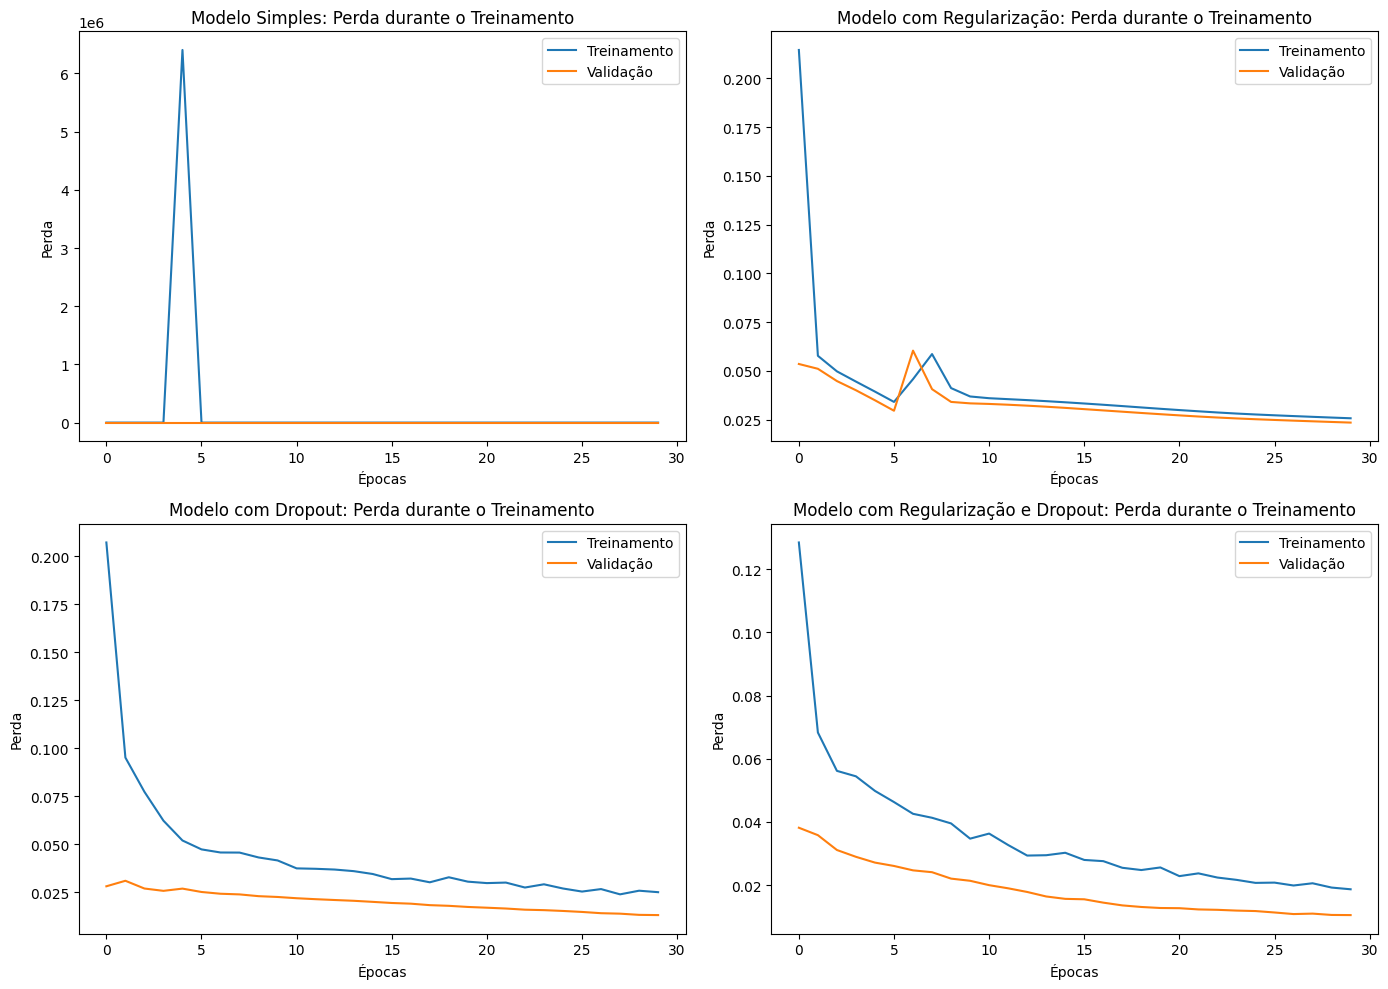

In [69]:
#Plot do Grafico de Perda
plot_multiple_loss(history_lstm, history_lstm_reg, history_lstm_drop, history_lstm_reg_drop)

In [70]:
# Obtendo as previsões dos quatro modelos
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_reg = model_lstm_reg.predict(X_test)
y_pred_lstm_drop = model_lstm_drop.predict(X_test)
y_pred_lstm_reg_drop = model_lstm_reg_drop.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


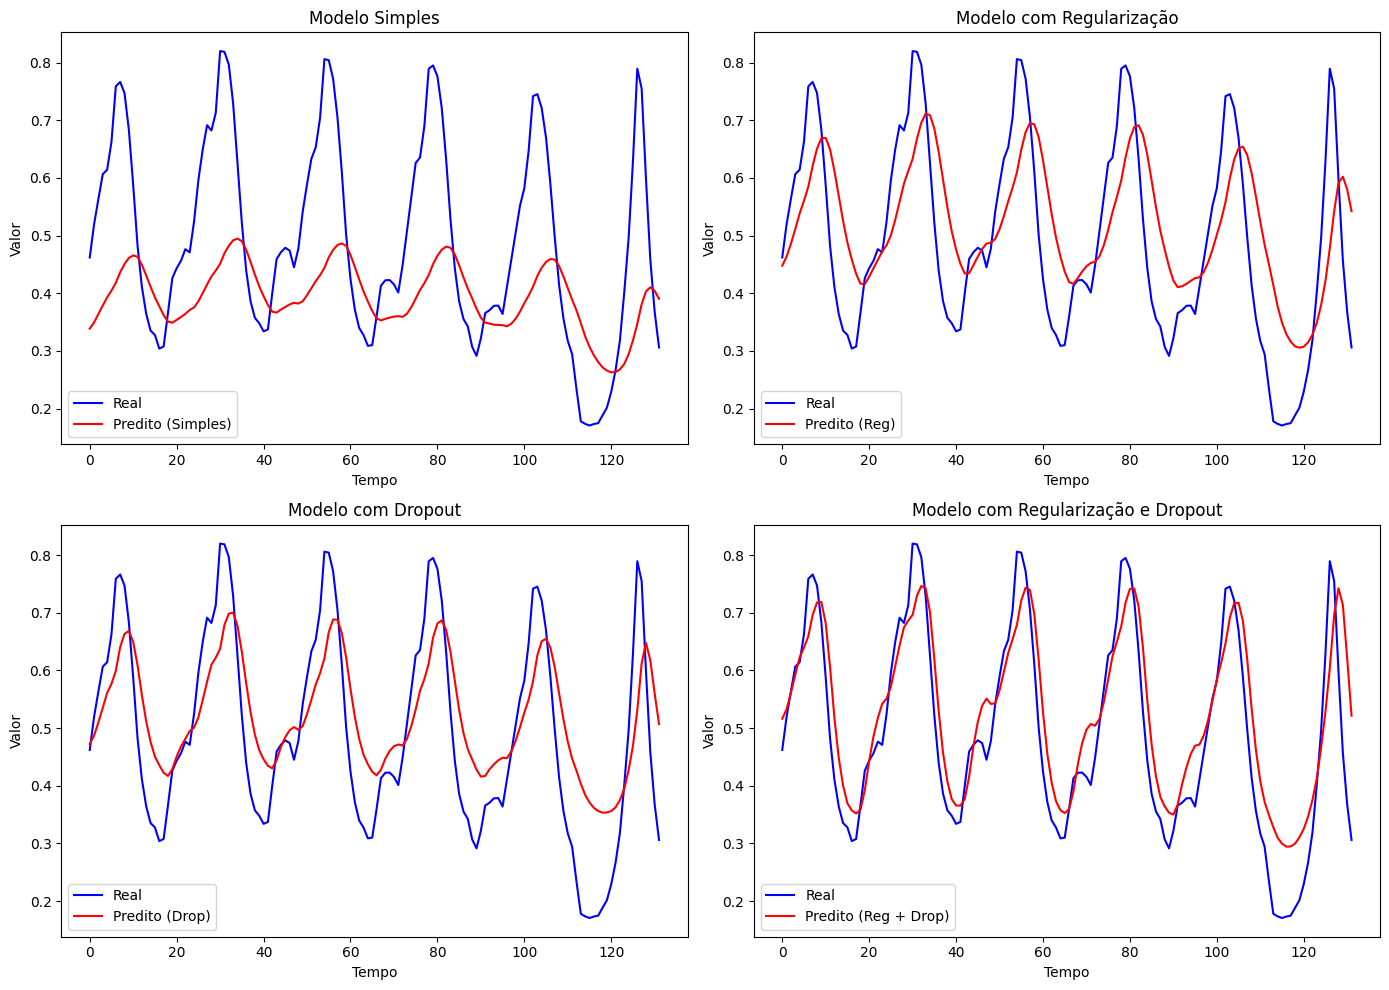

In [71]:
plot_predicts(y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop)

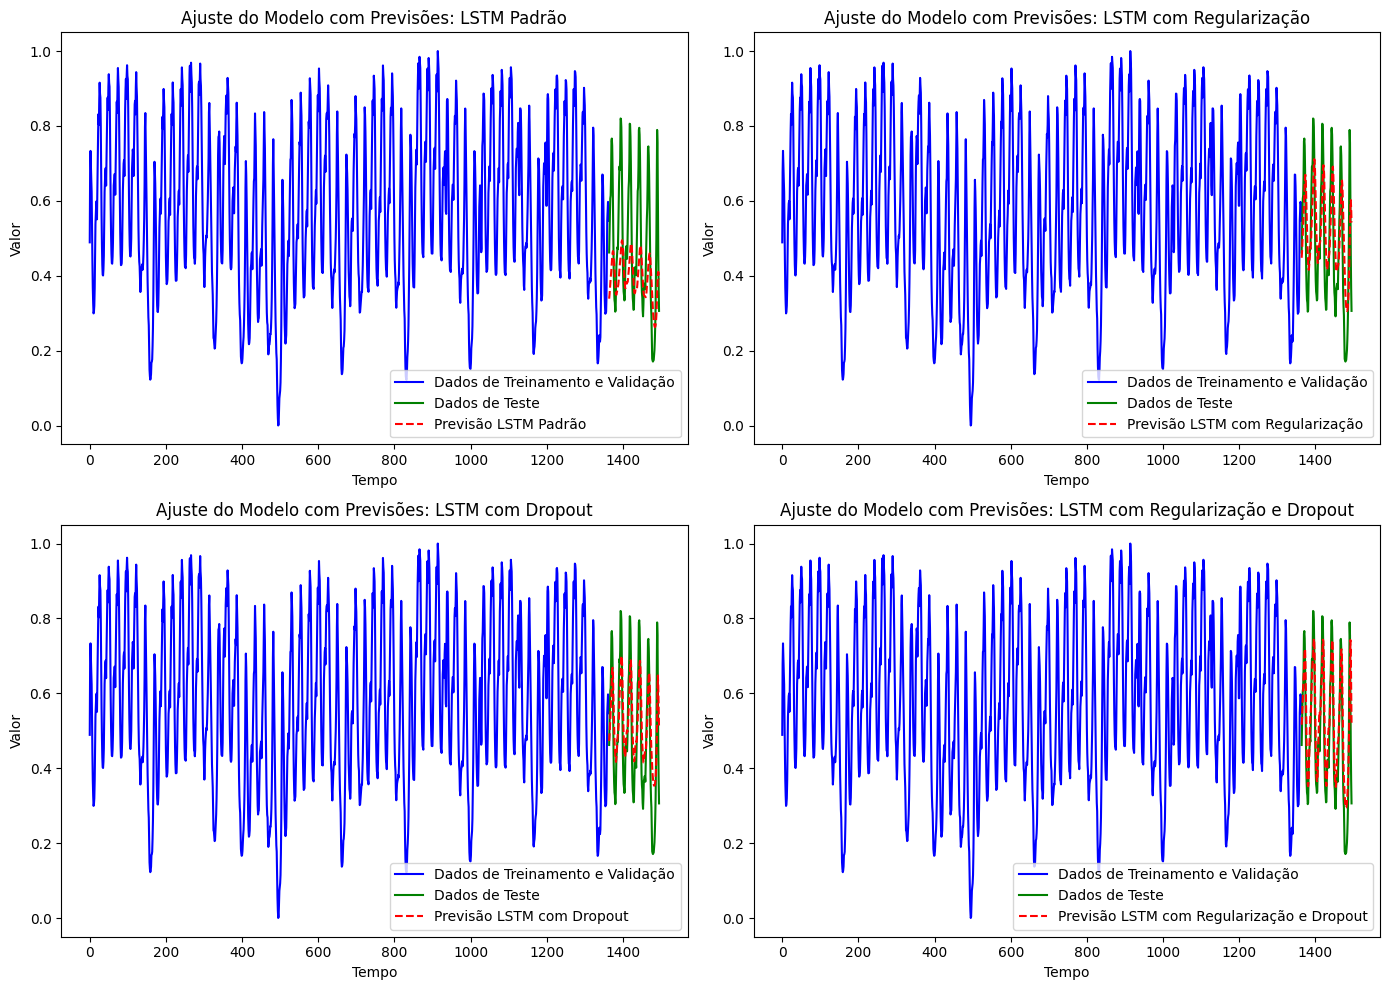

In [72]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_lstm, y_pred_lstm_reg, y_pred_lstm_drop, y_pred_lstm_reg_drop]
model_names = ["LSTM Padrão", "LSTM com Regularização", "LSTM com Dropout", "LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

## Pre-processamento dos dados

In [73]:
#Hiperparametros
epochs_hibrid = 30
batch_hibrid = 32
lr_hibrid = 0.001
subsequences = 2
neu_cnn = 256 #Quantidade de Neuronios na Camada de CNN
neu_lstm = 64 #Quantidade de Neuronios na Camada de LSTM

In [74]:
timesteps = X_train.shape[1]//subsequences
X_train_series_sub = X_train.reshape((X_train.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid.reshape((X_valid.shape[0], subsequences, timesteps, 1))
X_test_series_sub = X_test.reshape((X_test.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)
print('Test set shape', X_test_series_sub.shape)

Train set shape (1232, 2, 84, 1)
Validation set shape (132, 2, 84, 1)
Test set shape (132, 2, 84, 1)


### Analisando a Quantidade de Neuronios

In [75]:
def create_mlp_model(neurons_layer_1, neurons_layer_2):
    model_cnn_lstm = Sequential()
    model_cnn_lstm.add(TimeDistributed(Conv1D(filters=neurons_layer_1, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
    model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model_cnn_lstm.add(TimeDistributed(Flatten()))
    model_cnn_lstm.add(LSTM(neurons_layer_2, activation='relu'))
    model_cnn_lstm.add(Dense(1))
    model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))
    return model


# Listas de neurônios para a primeira e segunda camada
neurons_layer_1_options_cnn_lstm = [32, 64, 128, 256]
neurons_layer_2_options_cnn_lstm = [32, 64, 128, 256]

# Armazenar resultados
results_cnn_lstm = []

Treinando modelo com 32 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 256 neurônios na prim

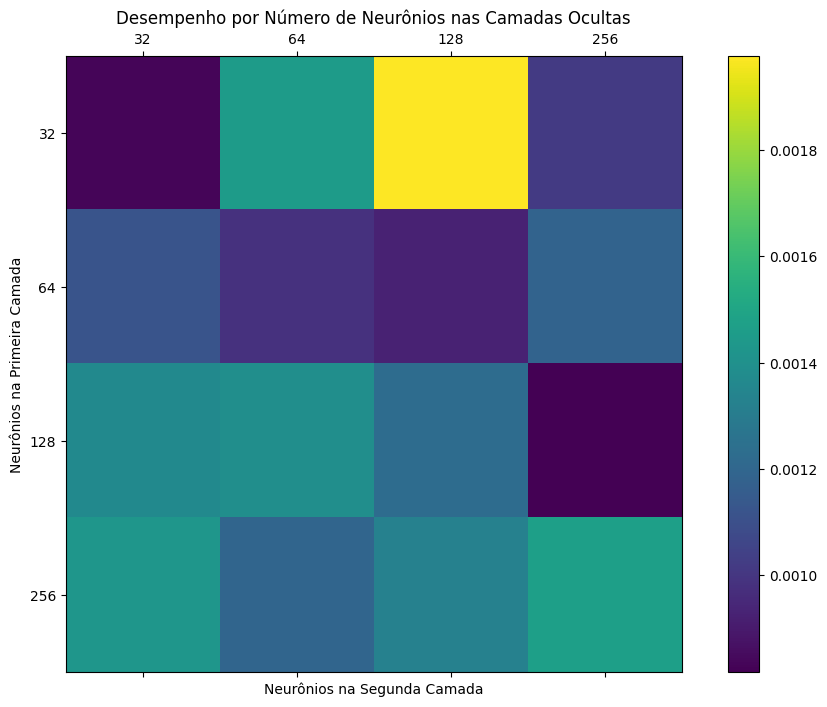

In [76]:
# Loop para testar todas as combinações possíveis de neurônios
for neurons_layer_1 in neurons_layer_1_options_cnn_lstm:
    for neurons_layer_2 in neurons_layer_2_options_cnn_lstm:
        print(f"Treinando modelo com {neurons_layer_1} neurônios na primeira camada e {neurons_layer_2} na segunda camada...")

        # Criar o modelo
        model = create_mlp_model(neurons_layer_1, neurons_layer_2)

        # Treinar o modelo
        history = model.fit(X_train, Y_train, epochs=epochs_hibrid, batch_size=batch_hibrid, validation_data=(X_valid, Y_valid), verbose=0)

        # Obter o desempenho (pode ser MAPE, RMSE, etc.)
        val_loss = history.history['val_loss'][-1]

        # Armazenar o desempenho
        results_cnn_lstm.append({'neurons_layer_1': neurons_layer_1, 'neurons_layer_2': neurons_layer_2, 'val_loss': val_loss})


results_df = pd.DataFrame(results_cnn_lstm)

# Gerar gráfico
fig, ax = plt.subplots(figsize=(12,8))

# Gerar gráfico de calor (heatmap)
pivot_table = results_df.pivot(index='neurons_layer_1', columns='neurons_layer_2', values='val_loss')
cax = ax.matshow(pivot_table, cmap='viridis')

# Adicionar rótulos
ax.set_xticks(np.arange(len(neurons_layer_2_options_cnn_lstm)))
ax.set_yticks(np.arange(len(neurons_layer_1_options_cnn_lstm)))
ax.set_xticklabels(neurons_layer_2_options_cnn_lstm)
ax.set_yticklabels(neurons_layer_1_options_cnn_lstm)

# Adicionar título e legendas
plt.xlabel('Neurônios na Segunda Camada')
plt.ylabel('Neurônios na Primeira Camada')
plt.title('Desempenho por Número de Neurônios nas Camadas Ocultas')
fig.colorbar(cax)

plt.show()

## Implementacao e ajuste do modelo padrao

In [77]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(neu_lstm, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [78]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_series_sub,
                                      Y_train,
                                      validation_data=(X_valid_series_sub, Y_valid),
                                      epochs=epochs_hibrid,
                                      batch_size = batch_hibrid,
                                      verbose=1)

Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.1016 - val_loss: 0.0216
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0181 - val_loss: 0.0101
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0102 - val_loss: 0.0049
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0074 - val_loss: 0.0037
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0071 - val_loss: 0.0045
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0

## Implementacao e Ajuste do modelo com Regularizacao

In [79]:
model_cnn_lstm_reg = Sequential()
model_cnn_lstm_reg.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg.add(LSTM(neu_lstm, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg.add(Dense(1))
model_cnn_lstm_reg.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [80]:
history_cnn_lstm_reg = model_cnn_lstm_reg.fit(X_train_series_sub,
                                              Y_train,
                                              validation_data=(X_valid_series_sub, Y_valid),
                                              epochs=epochs_hibrid,
                                              batch_size = batch_hibrid,
                                              verbose=1)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - loss: 0.3073 - val_loss: 0.0509
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0463 - val_loss: 0.0285
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0306 - val_loss: 0.0225
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0236 - val_loss: 0.0145
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0177 - val_loss: 0.0117
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0156 - val_loss: 0.0098
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0127 - val_loss: 0.0098
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0120 - val_loss: 0.0099
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0109 - val_loss: 0.0080
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step

## Implementacao e Ajuste do Modelo com Dropout

In [81]:
model_cnn_lstm_drop = Sequential()
model_cnn_lstm_drop.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_drop.add(Dropout(droprate))
model_cnn_lstm_drop.add(LSTM(neu_lstm, activation='relu'))
model_cnn_lstm_drop.add(Dropout(droprate))
model_cnn_lstm_drop.add(Dense(1))
model_cnn_lstm_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

In [82]:
history_cnn_lstm_drop = model_cnn_lstm_drop.fit(X_train_series_sub,
                                                Y_train,
                                                validation_data=(X_valid_series_sub, Y_valid),
                                                epochs=epochs_hibrid,
                                                batch_size = batch_hibrid,
                                                verbose=1)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.1291 - val_loss: 0.0148
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0219 - val_loss: 0.0078
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0184 - val_loss: 0.0060
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0159 - val_loss: 0.0052
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0144 - val_loss: 0.0040
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0136 - val_loss: 0.0031
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0127 - val_loss: 0.0029
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0115 - val_loss: 0.0059
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0126 - val_loss: 0.0035
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0128 - val_loss: 0.0023
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0120 - val_loss: 0.0024
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step

## Implementacao e Ajuste do Modelo com Regularizacao e Dropout

In [83]:
model_cnn_lstm_reg_drop = Sequential()
model_cnn_lstm_reg_drop.add(TimeDistributed(Conv1D(filters=neu_cnn, kernel_size=1, activation='relu', kernel_regularizer=regularizers.l2(0.001)), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm_reg_drop.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model_cnn_lstm_reg_drop.add(TimeDistributed(Flatten()))
model_cnn_lstm_reg_drop.add(Dropout(droprate))
model_cnn_lstm_reg_drop.add(LSTM(neu_lstm, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn_lstm_reg_drop.add(Dropout(droprate))
model_cnn_lstm_reg_drop.add(Dense(1))
model_cnn_lstm_reg_drop.compile(loss='mse', optimizer=optimizers.Adam(lr_hibrid))

history_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.fit(X_train_series_sub,
                                                        Y_train,
                                                        validation_data=(X_valid_series_sub, Y_valid),
                                                        epochs=epochs_hibrid,
                                                        batch_size = batch_hibrid,
                                                        verbose=1)


Epoch 1/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - loss: 0.3580 - val_loss: 0.0759
Epoch 2/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0738 - val_loss: 0.0427
Epoch 3/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0477 - val_loss: 0.0387
Epoch 4/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0389 - val_loss: 0.0210
Epoch 5/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0309 - val_loss: 0.0189
Epoch 6/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0281 - val_loss: 0.0151
Epoch 7/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0259 - val_loss: 0.0160
Epoch 8/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0274 - val_loss: 0.0141
Epoch 9/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0254 - val_loss: 0.0279
Epoch 10/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0253 - val_loss: 0.0179
Epoch 11/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0238 - val_loss: 0.0100
Epoch 12/30
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step

## Comparativo entre os modelos

In [84]:
# Realizando previsões para cada modelo
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)
y_pred_cnn_lstm_reg = model_cnn_lstm_reg.predict(X_test_series_sub)
y_pred_cnn_lstm_drop = model_cnn_lstm_drop.predict(X_test_series_sub)
y_pred_cnn_lstm_reg_drop = model_cnn_lstm_reg_drop.predict(X_test_series_sub)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step


In [85]:
# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard, mape_standard = evaluate_model(model_cnn_lstm, X_test_series_sub, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg, mape_reg = evaluate_model(model_cnn_lstm_reg, X_test_series_sub, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout, mape_dropout = evaluate_model(model_cnn_lstm_drop, X_test_series_sub, Y_test, "Modelo com Dropout")
mae_reg_drop, mse_reg_drop, rmse_reg_drop, mape_reg_drop = evaluate_model(model_cnn_lstm_reg_drop, X_test_series_sub, Y_test, "Modelo com Regularização e Dropout")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Modelo Padrão:
MAE: 0.0298
MSE: 0.0016
RMSE: 0.0405
MAPE: 7.5054%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Modelo com Regularização:
MAE: 0.0396
MSE: 0.0029
RMSE: 0.0538
MAPE: 10.9778%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Modelo com Dropout:
MAE: 0.0420
MSE: 0.0028
RMSE: 0.0529
MAPE: 9.5949%
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

Modelo com Regularização e Dropout:
MAE: 0.0403
MSE: 0.0028
RMSE: 0.0529
MAPE: 11.4763%


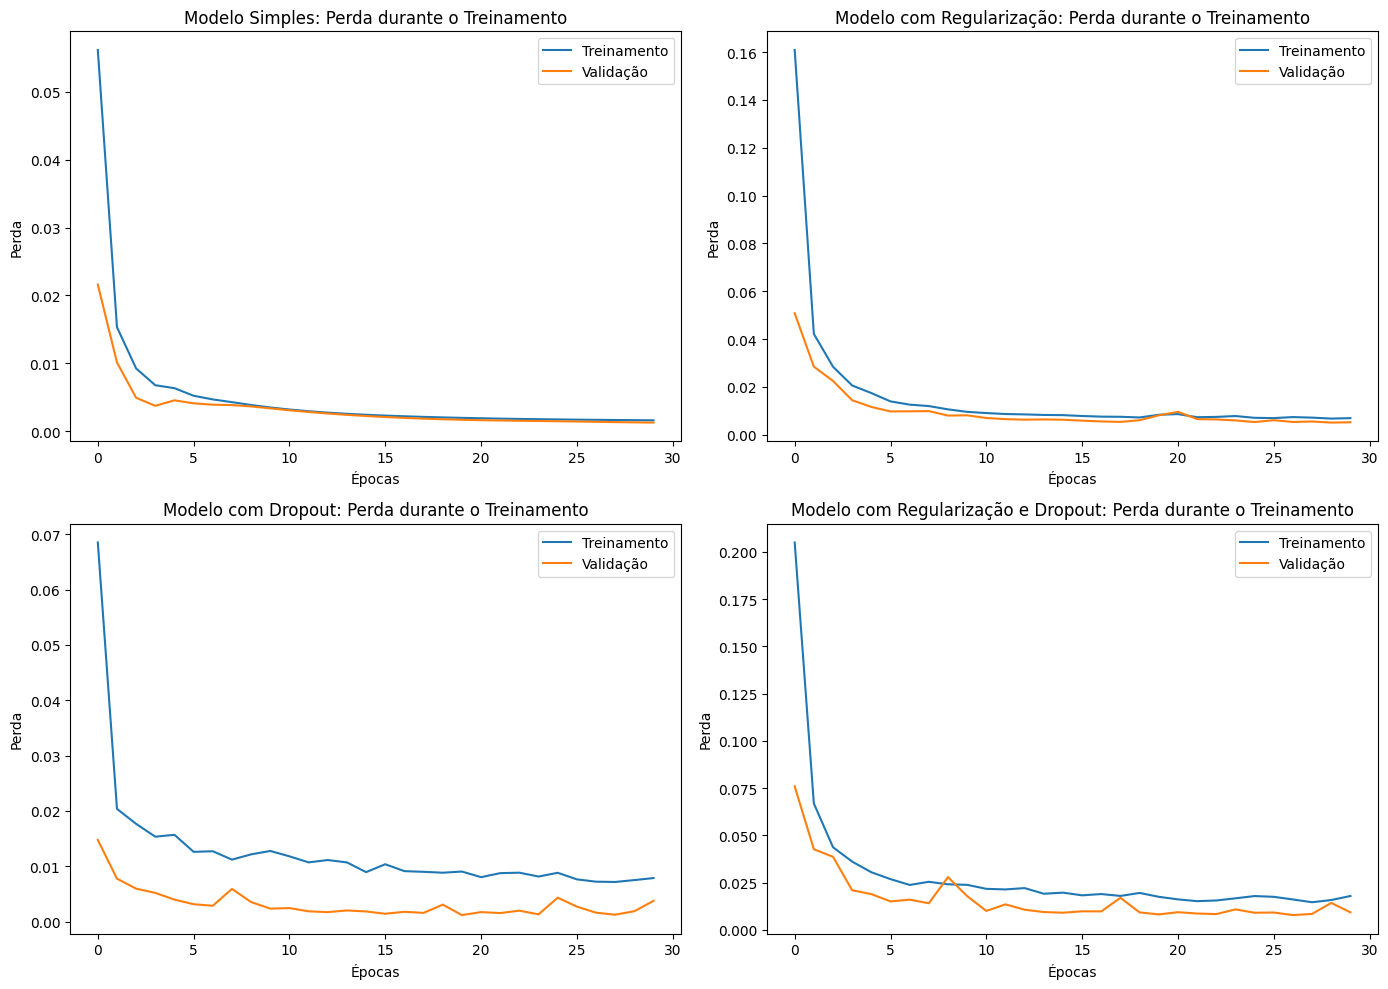

In [86]:
#Plot do Grafico de Perda
plot_multiple_loss(history_cnn_lstm, history_cnn_lstm_reg, history_cnn_lstm_drop, history_cnn_lstm_reg_drop)

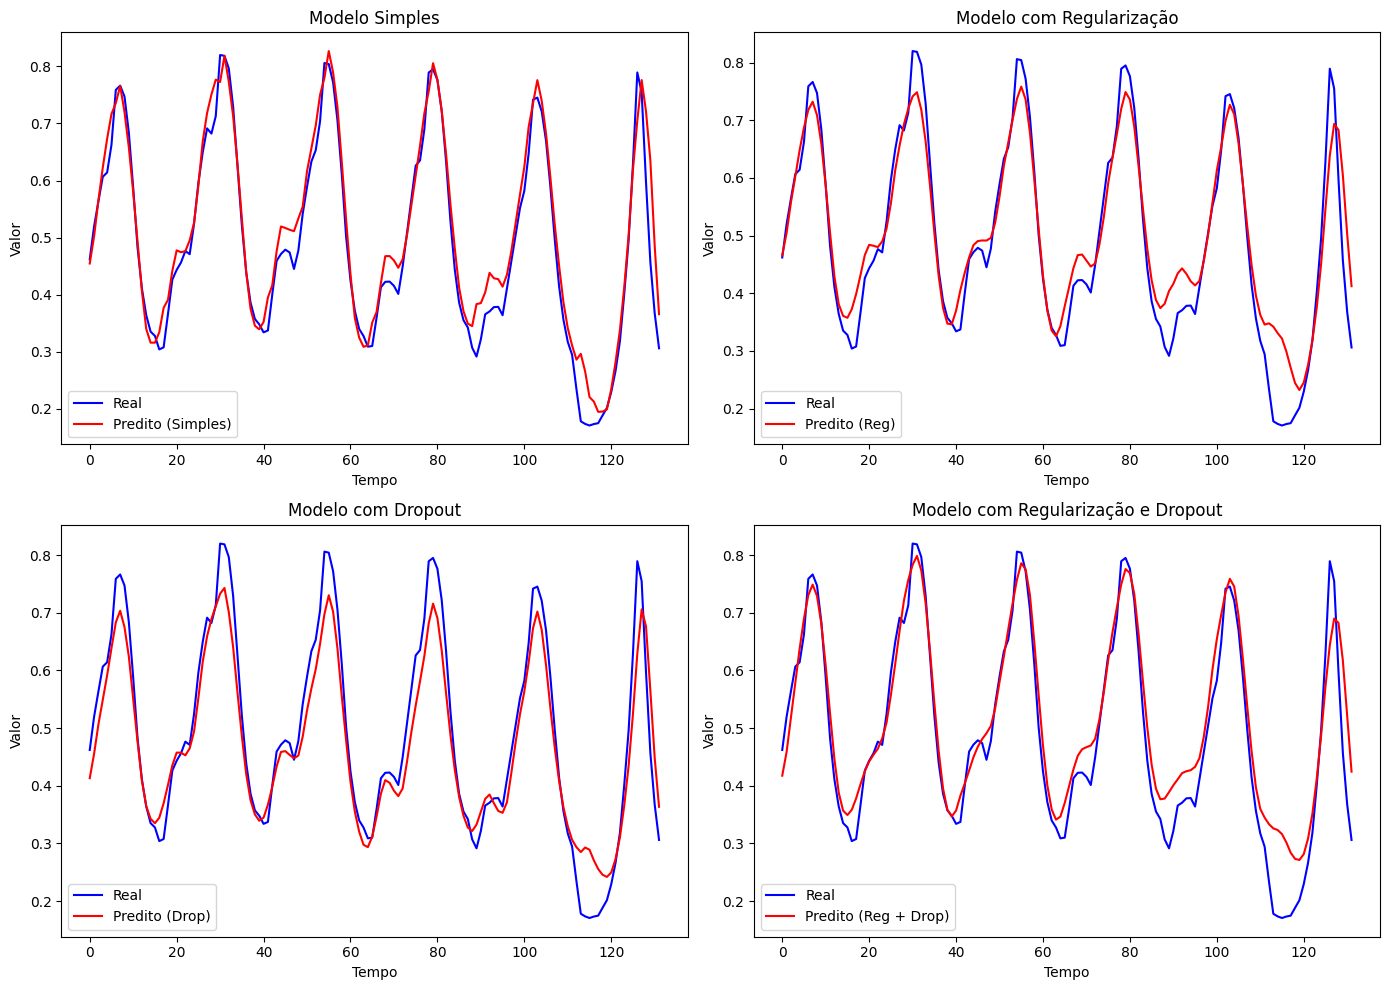

In [87]:
plot_predicts(y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop)

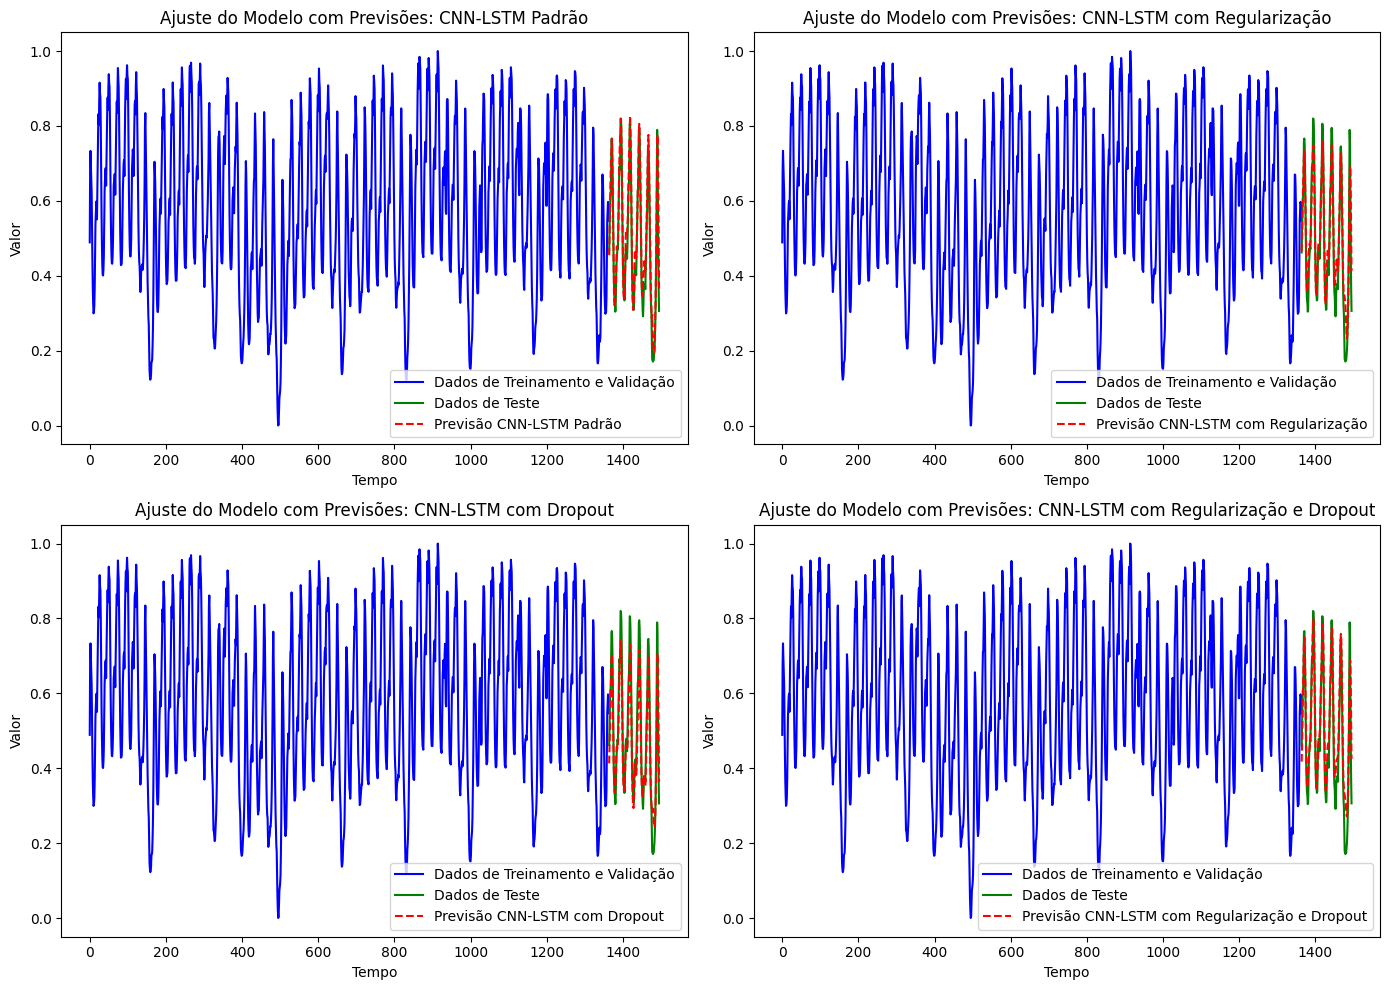

In [88]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

# Lista com previsões e nomes dos modelos para plotar
y_pred_models = [y_pred_cnn_lstm, y_pred_cnn_lstm_reg, y_pred_cnn_lstm_drop, y_pred_cnn_lstm_reg_drop]
model_names = ["CNN-LSTM Padrão", "CNN-LSTM com Regularização", "CNN-LSTM com Dropout", "CNN-LSTM com Regularização e Dropout"]

# Chamando a função para exibir os gráficos lado a lado
plot_multiple_predictions(train_valid_data, Y_test, y_pred_models, model_names)

# Testando Looping de Neuronios


Treinando modelo com 16 neurônios...
Treinando modelo com 24 neurônios...
Treinando modelo com 32 neurônios...
Treinando modelo com 48 neurônios...
Treinando modelo com 64 neurônios...
Treinando modelo com 82 neurônios...
Treinando modelo com 128 neurônios...
Treinando modelo com 256 neurônios...
Treinando modelo com 512 neurônios...


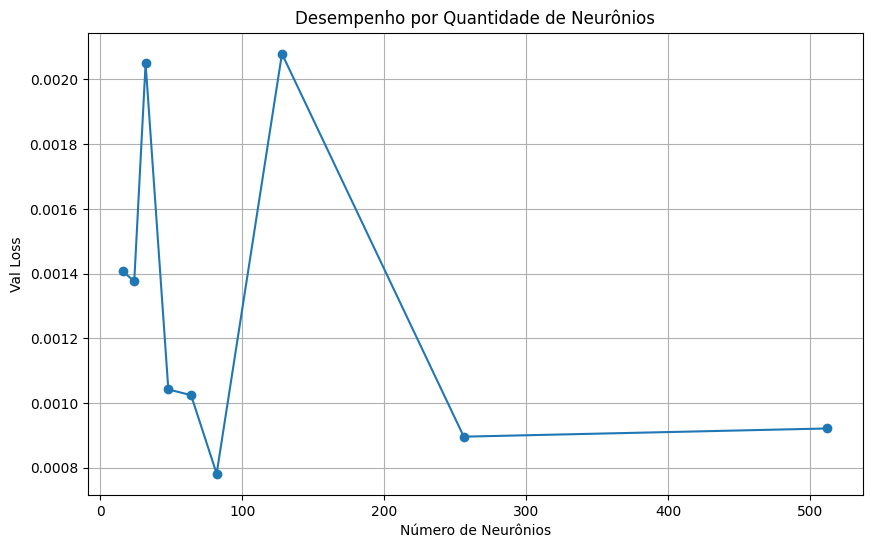

In [89]:
import matplotlib.pyplot as plt

# Definir a função de criação do modelo MLP (como exemplo)
def create_mlp_model(neurons):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1))  # Camada de saída para regressão
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Lista de diferentes quantidades de neurônios a testar
neurons_options = [16, 24, 32, 48, 64, 82, 128, 256, 512]

# Armazenar resultados
results = []

# Loop para testar diferentes quantidades de neurônios
for neurons in neurons_options:
    print(f"Treinando modelo com {neurons} neurônios...")
    
    # Criar o modelo
    model = create_mlp_model(neurons)
    
    # Treinar o modelo
    history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=0)
    
    # Obter o desempenho (pode ser MAPE, RMSE, etc.)
    val_loss = history.history['val_loss'][-1]
    
    # Armazenar o desempenho
    results.append({'neurons': neurons, 'val_loss': val_loss})

# Converter para dataframe (opcional)
import pandas as pd
results_df = pd.DataFrame(results)

# Gerar gráfico
plt.figure(figsize=(10,6))
plt.plot(results_df['neurons'], results_df['val_loss'], marker='o')
plt.title('Desempenho por Quantidade de Neurônios')
plt.xlabel('Número de Neurônios')
plt.ylabel('Val Loss')
plt.grid(True)
plt.show()


Treinando modelo com 32 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 32 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 64 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 32 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 64 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 128 na segunda camada...
Treinando modelo com 128 neurônios na primeira camada e 256 na segunda camada...
Treinando modelo com 256 neurônios na prim

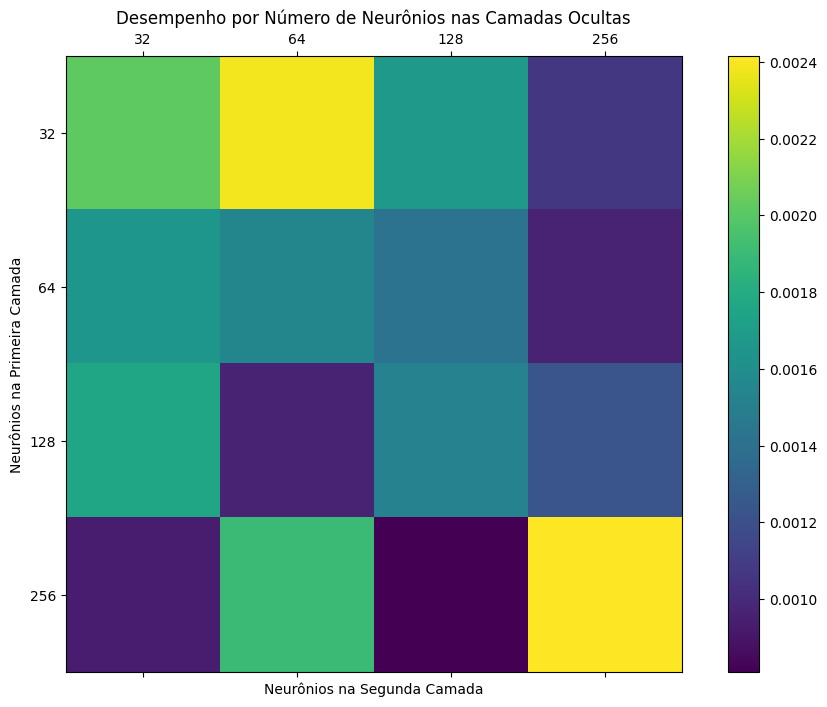

In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Função de criação do modelo MLP com 2 camadas ocultas
def create_mlp_model(neurons_layer_1, neurons_layer_2):
    model = Sequential()
    model.add(Dense(neurons_layer_1, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(neurons_layer_2, activation='relu'))  # Segunda camada
    model.add(Dense(1))  # Camada de saída para regressão
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Listas de neurônios para a primeira e segunda camada
neurons_layer_1_options = [32, 64, 128, 256]
neurons_layer_2_options = [32, 64, 128, 256]

# Armazenar resultados
results = []

# Loop para testar todas as combinações possíveis de neurônios
for neurons_layer_1 in neurons_layer_1_options:
    for neurons_layer_2 in neurons_layer_2_options:
        print(f"Treinando modelo com {neurons_layer_1} neurônios na primeira camada e {neurons_layer_2} na segunda camada...")

        # Criar o modelo
        model = create_mlp_model(neurons_layer_1, neurons_layer_2)

        # Treinar o modelo
        history = model.fit(X_train, Y_train, epochs=35, batch_size=32, validation_data=(X_valid, Y_valid), verbose=0)

        # Obter o desempenho (pode ser MAPE, RMSE, etc.)
        val_loss = history.history['val_loss'][-1]

        # Armazenar o desempenho
        results.append({'neurons_layer_1': neurons_layer_1, 'neurons_layer_2': neurons_layer_2, 'val_loss': val_loss})

# Converter para dataframe (opcional)
import pandas as pd
results_df = pd.DataFrame(results)

# Gerar gráfico
fig, ax = plt.subplots(figsize=(12,8))

# Gerar gráfico de calor (heatmap)
pivot_table = results_df.pivot(index='neurons_layer_1', columns='neurons_layer_2', values='val_loss')
cax = ax.matshow(pivot_table, cmap='viridis')

# Adicionar rótulos
ax.set_xticks(np.arange(len(neurons_layer_2_options)))
ax.set_yticks(np.arange(len(neurons_layer_1_options)))
ax.set_xticklabels(neurons_layer_2_options)
ax.set_yticklabels(neurons_layer_1_options)

# Adicionar título e legendas
plt.xlabel('Neurônios na Segunda Camada')
plt.ylabel('Neurônios na Primeira Camada')
plt.title('Desempenho por Número de Neurônios nas Camadas Ocultas')
fig.colorbar(cax)

plt.show()
